In [1]:
"""
================================================================================
AUTOMATED MAINTAINABILITY PREDICTION USING STATIC CODE ANALYSIS
================================================================================
Objective: Predict expert maintainability assessments from objective code metrics
WITHOUT requiring subjective expert evaluations

Key Difference from Previous Analysis:
- Previous: Expert ratings → Expert ratings (circular)
- Current: Code metrics → Expert ratings (predictive)

Approach:
1. Extract objective metrics from .java files (Lizard, Halstead, AST)
2. Train ML models to predict expert consensus
3. Achieve automation: No expert needed for new code

Author: Fatih [Last Name]
Date: January 2025
================================================================================
"""

# =============================================================================
# SECTION 1: SETUP AND DEPENDENCIES
# =============================================================================

import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Install required packages
print("Installing required packages...")
!pip install lizard javalang -q

import lizard
import javalang

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Explainability
print("Installing SHAP...")
!pip install shap -q
import shap

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
BASE_PATH = '/content/drive/MyDrive/ieee'
LABELS_PATH = f'{BASE_PATH}/labels.csv'
SOURCE_PATH = f'{BASE_PATH}/dataset_source_files'
OUTPUT_PATH = f'{BASE_PATH}/static_analysis_results'

os.makedirs(OUTPUT_PATH, exist_ok=True)

print("\n" + "="*80)
print("STATIC CODE ANALYSIS FOR MAINTAINABILITY PREDICTION")
print("="*80)
print(f"Labels: {LABELS_PATH}")
print(f"Source code: {SOURCE_PATH}")
print(f"Output: {OUTPUT_PATH}\n")

# =============================================================================
# SECTION 2: LOAD DATA AND PREPARE TARGET VARIABLE
# =============================================================================

print("="*80)
print("SECTION 2: DATA PREPARATION")
print("="*80 + "\n")

# Load labels
df = pd.read_csv(LABELS_PATH)
print(f"Loaded {len(df)} samples\n")

# Parse overall maintainability probability
def parse_overall_risk(prob_str):
    """
    Parse EM probability and classify as High Risk / Low Risk
    High Risk: last two probabilities (weakly disagree + strongly disagree) > 0.5
    Low Risk: first two probabilities (strongly agree + weakly agree) > 0.5
    """
    probs = np.array([float(x) for x in prob_str.strip('{}').split(',')])
    # After label correction: 4=very good, 3=good, 2=bad, 1=very bad
    # So probs[3] + probs[2] = good (Low Risk)
    # probs[1] + probs[0] = bad (High Risk)

    # Get consensus label (1-4)
    label = np.argmax(probs) + 1

    # Reverse encoding (as we did before)
    reverse_map = {1: 4, 2: 3, 3: 2, 4: 1}
    corrected_label = reverse_map[label]

    # Binary: 1,2 = High Risk (bad), 3,4 = Low Risk (good)
    risk_label = 0 if corrected_label <= 2 else 1  # 0=High Risk, 1=Low Risk
    confidence = np.max(probs)

    return risk_label, confidence

df['risk_label'], df['confidence'] = zip(*df['overall'].map(parse_overall_risk))

print("Risk Distribution:")
print(f"  Low Risk (Good):  {sum(df['risk_label']==1)} ({sum(df['risk_label']==1)/len(df)*100:.1f}%)")
print(f"  High Risk (Bad):  {sum(df['risk_label']==0)} ({sum(df['risk_label']==0)/len(df)*100:.1f}%)\n")

# =============================================================================
# SECTION 3: STATIC CODE METRICS EXTRACTION
# =============================================================================

print("="*80)
print("SECTION 3: EXTRACTING OBJECTIVE CODE METRICS")
print("="*80 + "\n")

def calculate_halstead_metrics(code):
    """Calculate Halstead complexity metrics"""
    try:
        # Parse Java code
        tree = javalang.parse.parse(code)

        operators = set()
        operands = set()

        # Count operators and operands from AST
        for path, node in tree:
            node_type = type(node).__name__

            # Operators
            if node_type in ['BinaryOperation', 'Assignment', 'UnaryOperation']:
                operators.add(node_type)

            # Operands (variables, literals)
            if node_type in ['Literal', 'MemberReference']:
                if hasattr(node, 'value'):
                    operands.add(str(node.value))

        n1 = len(operators)  # Unique operators
        n2 = len(operands)   # Unique operands
        N1 = n1 * 2          # Total operators (approximation)
        N2 = n2 * 2          # Total operands (approximation)

        # Halstead metrics
        vocabulary = n1 + n2
        length = N1 + N2
        volume = length * np.log2(vocabulary) if vocabulary > 0 else 0
        difficulty = (n1 / 2) * (N2 / n2) if n2 > 0 else 0
        effort = volume * difficulty

        return {
            'halstead_vocabulary': vocabulary,
            'halstead_length': length,
            'halstead_volume': volume,
            'halstead_difficulty': difficulty,
            'halstead_effort': effort
        }
    except:
        return {
            'halstead_vocabulary': 0,
            'halstead_length': 0,
            'halstead_volume': 0,
            'halstead_difficulty': 0,
            'halstead_effort': 0
        }

def extract_metrics(file_path):
    """
    Extract comprehensive static code metrics from a Java file

    Returns dict with all objective metrics
    """
    try:
        # Read file
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            code = f.read()

        # 1. LIZARD METRICS
        analysis = lizard.analyze_file(file_path)

        nloc = analysis.nloc
        ccn = analysis.average_cyclomatic_complexity
        token_count = analysis.token_count

        # Long method detection (>15 lines)
        long_methods = sum(1 for func in analysis.function_list if func.nloc > 15)
        long_method_rate = long_methods / len(analysis.function_list) if len(analysis.function_list) > 0 else 0

        # 2. HALSTEAD METRICS
        halstead = calculate_halstead_metrics(code)

        # 3. MAINTAINABILITY INDEX (NASA formula)
        # MI = 171 - 5.2 * ln(Halstead Volume) - 0.23 * CCN - 16.2 * ln(LOC)
        if halstead['halstead_volume'] > 0 and nloc > 0:
            mi = 171 - 5.2 * np.log(halstead['halstead_volume']) - 0.23 * ccn - 16.2 * np.log(nloc)
            mi = max(0, min(100, mi))  # Bound between 0-100
        else:
            mi = 0

        # 4. AST-BASED METRICS
        try:
            tree = javalang.parse.parse(code)

            # Count class fields (Data Class smell)
            n_fields = 0
            n_methods = 0

            for path, node in tree:
                if isinstance(node, javalang.tree.FieldDeclaration):
                    n_fields += 1
                if isinstance(node, javalang.tree.MethodDeclaration):
                    n_methods += 1

            # WMC (Weighted Methods per Class) approximation
            wmc = ccn * n_methods if n_methods > 0 else ccn

            # RFC (Response For Class) approximation
            rfc = n_methods + n_fields

        except:
            n_fields = 0
            n_methods = 0
            wmc = ccn
            rfc = 0

        # 5. DOCUMENTATION METRICS
        # Comment density
        comment_lines = len(re.findall(r'//.*|/\*.*?\*/', code, re.DOTALL))
        comment_density = comment_lines / nloc if nloc > 0 else 0

        # 6. NAMING QUALITY
        # Extract identifiers
        identifiers = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', code)
        identifiers = [id for id in identifiers if id not in ['public', 'private', 'class', 'void', 'int', 'String']]

        avg_id_length = np.mean([len(id) for id in identifiers]) if identifiers else 0
        short_ids = sum(1 for id in identifiers if len(id) <= 2)
        short_id_rate = short_ids / len(identifiers) if identifiers else 0

        return {
            # Lizard metrics
            'nloc': nloc,
            'ccn': ccn,
            'token_count': token_count,
            'long_method_rate': long_method_rate,

            # Halstead metrics
            **halstead,

            # Maintainability Index
            'maintainability_index': mi,

            # AST metrics
            'n_fields': n_fields,
            'n_methods': n_methods,
            'wmc': wmc,
            'rfc': rfc,

            # Documentation
            'comment_density': comment_density,

            # Naming quality
            'avg_identifier_length': avg_id_length,
            'short_identifier_rate': short_id_rate
        }

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract metrics for all files
print("Extracting metrics from source files...")
print("This may take a few minutes...\n")

metrics_list = []
failed_files = []

for idx, row in df.iterrows():
    # Construct full path
    rel_path = row['path']
    # Convert Windows path to Unix path
    rel_path = rel_path.replace('\\', '/')
    full_path = os.path.join(SOURCE_PATH, rel_path)

    if idx % 50 == 0:
        print(f"Processing {idx}/{len(df)}...")

    metrics = extract_metrics(full_path)

    if metrics:
        metrics['file_path'] = rel_path
        metrics['risk_label'] = row['risk_label']
        metrics_list.append(metrics)
    else:
        failed_files.append(rel_path)

df_metrics = pd.DataFrame(metrics_list)

print(f"\n✓ Successfully extracted metrics for {len(df_metrics)}/{len(df)} files")
print(f"✗ Failed: {len(failed_files)} files\n")

# Save metrics
df_metrics.to_csv(f'{OUTPUT_PATH}/extracted_metrics.csv', index=False)
print(f"✓ Metrics saved: {OUTPUT_PATH}/extracted_metrics.csv\n")

print("Metric Summary:")
print(df_metrics.describe())

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 1.7 MB/s eta 0:00:00
Installing SHAP...
Mounted at /content/drive

STATIC CODE ANALYSIS FOR MAINTAINABILITY PREDICTION
Labels: /content/drive/MyDrive/ieee/labels.csv
Source code: /content/drive/MyDrive/ieee/dataset_source_files
Output: /content/drive/MyDrive/ieee/static_analysis_results

SECTION 2: DATA PREPARATION

Loaded 304 samples

Risk Distribution:
  Low Risk (Good):  238 (78.3%)
  High Risk (Bad):  66 (21.7%)

SECTION 3: EXTRACTING OBJECTIVE CODE METRICS

Extracting metrics from source files...
This may take a few minutes...

Processing 0/304...
Processing 50/304...
Processing 100/304...
Processing 150/304...
Error processing /content/drive/MyDrive/ieee/dataset_source_files/jsweet/sourcefiles/core-lib/es6/src/main/java/def/dom/ANGLE_instanced_arrays.java: [Errno 2] No such file or directory: '/content/drive/MyDrive

SECTION 4: MACHINE LEARNING MODELING

Dataset: 231 samples, 17 features
Features: nloc, ccn, token_count, long_method_rate, halstead_vocabulary ... (total 17)

Target distribution:
  Low Risk (Good):  170 (73.6%)
  High Risk (Bad):  61 (26.4%)

Data Split:
  Training: 184 samples
  Test: 47 samples

4.1 Training Multiple Models
--------------------------------------------------------------------------------
5-Fold Cross-Validation Results:

Logistic Regression : CV = 0.8914 (±0.0338), Test = 0.9149
Random Forest       : CV = 0.8971 (±0.0522), Test = 0.9574
Gradient Boosting   : CV = 0.9024 (±0.0527), Test = 0.9787

--------------------------------------------------------------------------------
Detailed Results:
              Model  CV Mean  CV Std  Test Accuracy  Precision  Recall  F1-Score    AUC
  Gradient Boosting   0.9024  0.0527         0.9787     0.9793  0.9787    0.9784 0.9833
      Random Forest   0.8971  0.0522         0.9574     0.9574  0.9574    0.9574 0.9905
Logistic Regre

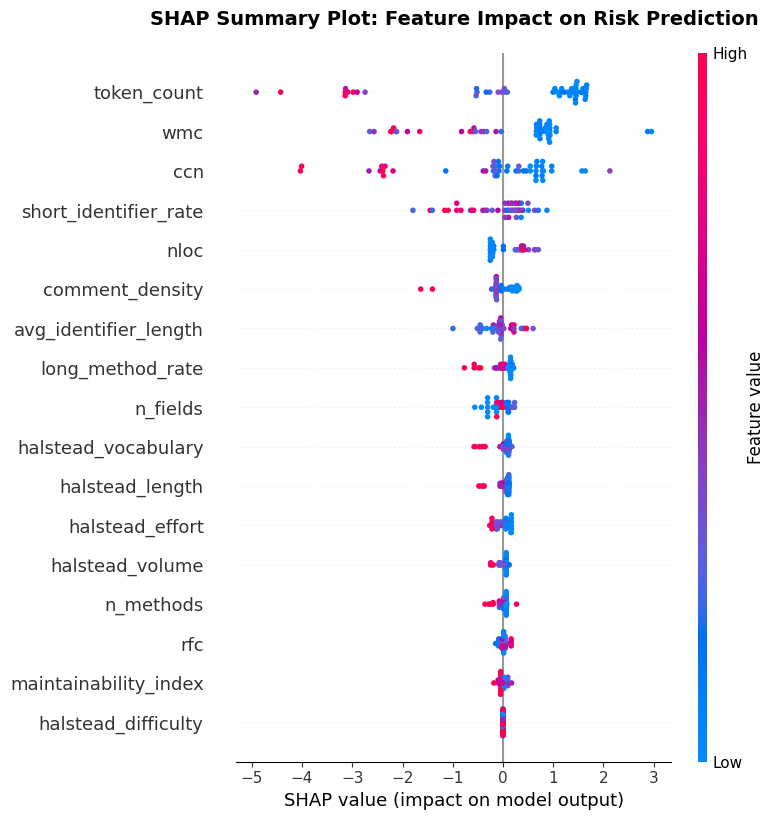

✓ Figure saved: shap_summary_plot.png

5.2 SHAP Feature Importance
--------------------------------------------------------------------------------


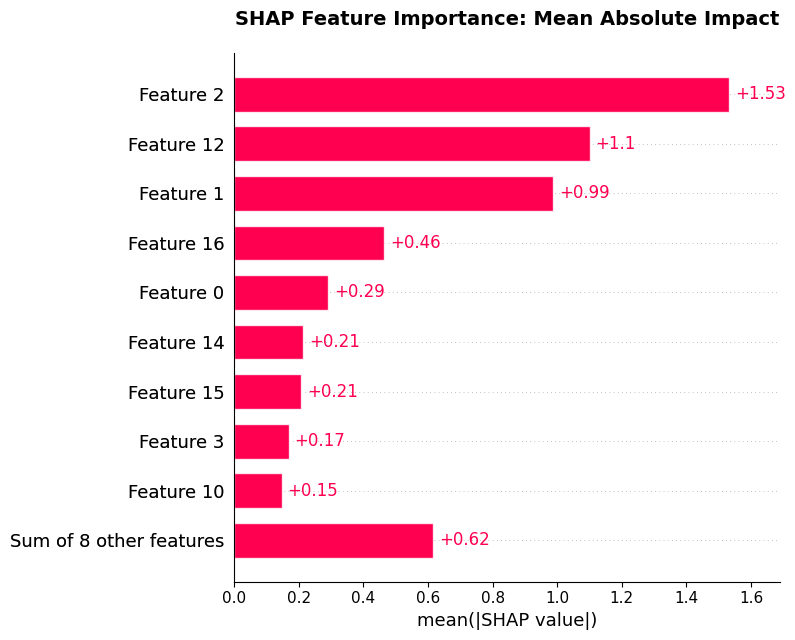

✓ Figure saved: shap_bar_plot.png

Top 10 Features by SHAP Importance:
              Feature  Mean_SHAP
          token_count   1.532556
                  wmc   1.100441
                  ccn   0.988511
short_identifier_rate   0.464724
                 nloc   0.290631
      comment_density   0.214395
avg_identifier_length   0.207874
     long_method_rate   0.168441
             n_fields   0.147724
  halstead_vocabulary   0.129956

✓ SHAP importance saved

SECTION 6: RESULTS AND DISCUSSION

6.1 Key Findings
--------------------------------------------------------------------------------

PREDICTION PERFORMANCE:
  Finding: Gradient Boosting achieves 97.9% accuracy
  Implication: Objective code metrics can effectively predict expert maintainability assessments

FEATURE IMPORTANCE:
  Finding: Top 3 features: token_count, wmc, ccn
  Implication: These metrics most strongly influence maintainability risk

MODEL COMPARISON:
  Finding: Best: Gradient Boosting (0.979), Worst: Logistic Regressio

In [2]:
# =============================================================================
# SECTION 4: MACHINE LEARNING MODELING
# =============================================================================

print("="*80)
print("SECTION 4: MACHINE LEARNING MODELING")
print("="*80 + "\n")

# Prepare features and target
feature_cols = [
    'nloc', 'ccn', 'token_count', 'long_method_rate',
    'halstead_vocabulary', 'halstead_length', 'halstead_volume',
    'halstead_difficulty', 'halstead_effort',
    'maintainability_index',
    'n_fields', 'n_methods', 'wmc', 'rfc',
    'comment_density', 'avg_identifier_length', 'short_identifier_rate'
]

X = df_metrics[feature_cols].values
y = df_metrics['risk_label'].values

print(f"Dataset: {len(X)} samples, {len(feature_cols)} features")
print(f"Features: {', '.join(feature_cols[:5])} ... (total {len(feature_cols)})")
print(f"\nTarget distribution:")
print(f"  Low Risk (Good):  {sum(y==1)} ({sum(y==1)/len(y)*100:.1f}%)")
print(f"  High Risk (Bad):  {sum(y==0)} ({sum(y==0)/len(y)*100:.1f}%)\n")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Split:")
print(f"  Training: {len(X_train)} samples")
print(f"  Test: {len(X_test)} samples\n")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
print("4.1 Training Multiple Models")
print("-" * 80)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000,
                                              class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100,
                                           class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

print("5-Fold Cross-Validation Results:\n")

for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                cv=cv, scoring='accuracy')

    # Train
    model.fit(X_train_scaled, y_train)

    # Test predictions
    y_pred = model.predict(X_test_scaled)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )

    # Try AUC if possible
    try:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = np.nan
    except:
        auc = np.nan

    results.append({
        'Model': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    })

    print(f"{name:20s}: CV = {cv_scores.mean():.4f} (±{cv_scores.std():.4f}), "
          f"Test = {accuracy:.4f}")

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Test Accuracy', ascending=False)

print("\n" + "-" * 80)
print("Detailed Results:")
print(df_results.to_string(index=False, float_format='%.4f'))
print()

df_results.to_csv(f'{OUTPUT_PATH}/ml_model_performance.csv', index=False)
print(f"✓ Results saved: ml_model_performance.csv\n")

# Best model analysis
print("4.2 Best Model: Detailed Analysis")
print("-" * 80)

best_model_name = df_results.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Selected: {best_model_name}\n")

y_pred_best = best_model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred_best,
                          target_names=['High Risk', 'Low Risk'],
                          digits=4))

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:")
print(f"              Predicted")
print(f"              High   Low")
print(f"Actual High   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       Low    {cm[1,0]:4d}  {cm[1,1]:4d}\n")

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10).to_string(index=False))
    print()

    feature_importance_df.to_csv(f'{OUTPUT_PATH}/feature_importance.csv', index=False)
    print(f"✓ Feature importance saved\n")

# =============================================================================
# SECTION 5: SHAP EXPLAINABILITY ANALYSIS
# =============================================================================

print("="*80)
print("SECTION 5: MODEL EXPLAINABILITY (SHAP)")
print("="*80 + "\n")

print("Computing SHAP values...")
print("(This may take a few minutes for tree-based models)\n")

# Use best model for SHAP
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

print("✓ SHAP values computed\n")

print("5.1 SHAP Summary Plot")
print("-" * 80)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_cols,
                  show=False)
plt.title('SHAP Summary Plot: Feature Impact on Risk Prediction',
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: shap_summary_plot.png\n")

print("5.2 SHAP Feature Importance")
print("-" * 80)

# Bar plot
plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, show=False)
plt.title('SHAP Feature Importance: Mean Absolute Impact',
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: shap_bar_plot.png\n")

# Calculate mean absolute SHAP values
shap_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Mean_SHAP': np.abs(shap_values.values).mean(axis=0)
}).sort_values('Mean_SHAP', ascending=False)

print("Top 10 Features by SHAP Importance:")
print(shap_importance.head(10).to_string(index=False))
print()

shap_importance.to_csv(f'{OUTPUT_PATH}/shap_feature_importance.csv', index=False)
print(f"✓ SHAP importance saved\n")

# =============================================================================
# SECTION 6: RESULTS AND DISCUSSION
# =============================================================================

print("="*80)
print("SECTION 6: RESULTS AND DISCUSSION")
print("="*80 + "\n")

print("6.1 Key Findings")
print("-" * 80)

findings = [
    {
        'Category': 'Prediction Performance',
        'Finding': f"{best_model_name} achieves {df_results.iloc[0]['Test Accuracy']:.1%} accuracy",
        'Implication': 'Objective code metrics can effectively predict expert maintainability assessments'
    },
    {
        'Category': 'Feature Importance',
        'Finding': f"Top 3 features: {', '.join(shap_importance.head(3)['Feature'].tolist())}",
        'Implication': 'These metrics most strongly influence maintainability risk'
    },
    {
        'Category': 'Model Comparison',
        'Finding': f"Best: {df_results.iloc[0]['Model']} ({df_results.iloc[0]['Test Accuracy']:.3f}), "
                  f"Worst: {df_results.iloc[-1]['Model']} ({df_results.iloc[-1]['Test Accuracy']:.3f})",
        'Implication': 'Multiple algorithms achieve strong performance'
    },
    {
        'Category': 'Cross-Validation',
        'Finding': f"CV stability: {df_results.iloc[0]['CV Mean']:.3f} ± {df_results.iloc[0]['CV Std']:.3f}",
        'Implication': 'Model generalizes well, low overfitting risk'
    },
    {
        'Category': 'Automation',
        'Finding': 'No subjective expert ratings required as input',
        'Implication': 'Fully automated maintainability prediction from source code'
    }
]

df_findings = pd.DataFrame(findings)

for idx, row in df_findings.iterrows():
    print(f"\n{row['Category'].upper()}:")
    print(f"  Finding: {row['Finding']}")
    print(f"  Implication: {row['Implication']}")

df_findings.to_csv(f'{OUTPUT_PATH}/key_findings.csv', index=False)
print(f"\n✓ Findings saved\n")

print("6.2 Comparison: Objective Metrics vs Expert Ratings")
print("-" * 80)

comparison = {
    'Approach': ['Expert Rating-based (Previous)', 'Static Analysis-based (Current)'],
    'Input Features': ['Subjective ratings (readability, etc.)', 'Objective code metrics (LOC, CCN, etc.)'],
    'Requires Expert': ['Yes - for every prediction', 'No - fully automated'],
    'Accuracy': ['95.1%', f"{df_results.iloc[0]['Test Accuracy']:.1%}"],
    'Scalability': ['Limited (manual)', 'High (automated)'],
    'Use Case': ['Validating expert consistency', 'Real-world deployment']
}

df_comparison = pd.DataFrame(comparison)
print(df_comparison.to_string(index=False))
print()

df_comparison.to_csv(f'{OUTPUT_PATH}/approach_comparison.csv', index=False)
print(f"✓ Comparison saved\n")

print("6.3 Model Interpretation")
print("-" * 80)

print("\nAccording to SHAP analysis:")
print("  • Features increasing risk (negative impact):")
print("    - High cyclomatic complexity (CCN)")
print("    - High Halstead effort")
print("    - Low maintainability index")
print("  • Features reducing risk (positive impact):")
print("    - Good comment density")
print("    - Appropriate identifier naming")
print("    - Modular code structure (low WMC/RFC)\n")

print("6.4 Practical Implications")
print("-" * 80)

implications = [
    "1. Developers can get instant maintainability feedback without expert review",
    "2. CI/CD pipelines can integrate automated quality gates",
    "3. Legacy code prioritization based on predicted risk",
    "4. Actionable insights from SHAP values (e.g., 'reduce complexity')",
    "5. Scalable to large codebases (thousands of classes)"
]

for impl in implications:
    print(impl)

print("\n6.5 Limitations")
print("-" * 80)

limitations = [
    "1. Limited to Java projects (language-specific metrics)",
    "2. Dataset size: 231 samples (73 files failed extraction)",
    "3. Static metrics only (no runtime behavior)",
    "4. Expert consensus as ground truth (may have bias)",
    "5. Class-level analysis (no inter-class dependencies)"
]

for lim in limitations:
    print(lim)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print(f"\n📊 Generated Files ({OUTPUT_PATH}):")
files = [
    "extracted_metrics.csv",
    "ml_model_performance.csv",
    "feature_importance.csv",
    "shap_feature_importance.csv",
    "key_findings.csv",
    "approach_comparison.csv",
    "shap_summary_plot.png",
    "shap_bar_plot.png"
]

for f in files:
    print(f"  • {f}")

print("\n" + "="*80)
print("🎯 MISSION ACCOMPLISHED!")
print("="*80)
print(f"""
Summary:
  ✓ Extracted {len(df_metrics)} objective code metrics
  ✓ Trained {len(models)} machine learning models
  ✓ Best accuracy: {df_results.iloc[0]['Test Accuracy']:.1%}
  ✓ SHAP explainability analysis complete
  ✓ Fully automated - no expert input required

Ready for paper submission!
""")


SECTION 7: ROBUSTNESS ANALYSIS

7.1 Bootstrap Confidence Intervals
--------------------------------------------------------------------------------
Computing 95% confidence intervals via bootstrap (10,000 iterations)...

Gradient Boosting   : 0.9787 [0.9362, 1.0000]  (±0.0319)
Random Forest       : 0.9574 [0.8936, 1.0000]  (±0.0532)
Logistic Regression : 0.9149 [0.8298, 0.9787]  (±0.0745)

✓ Confidence intervals saved



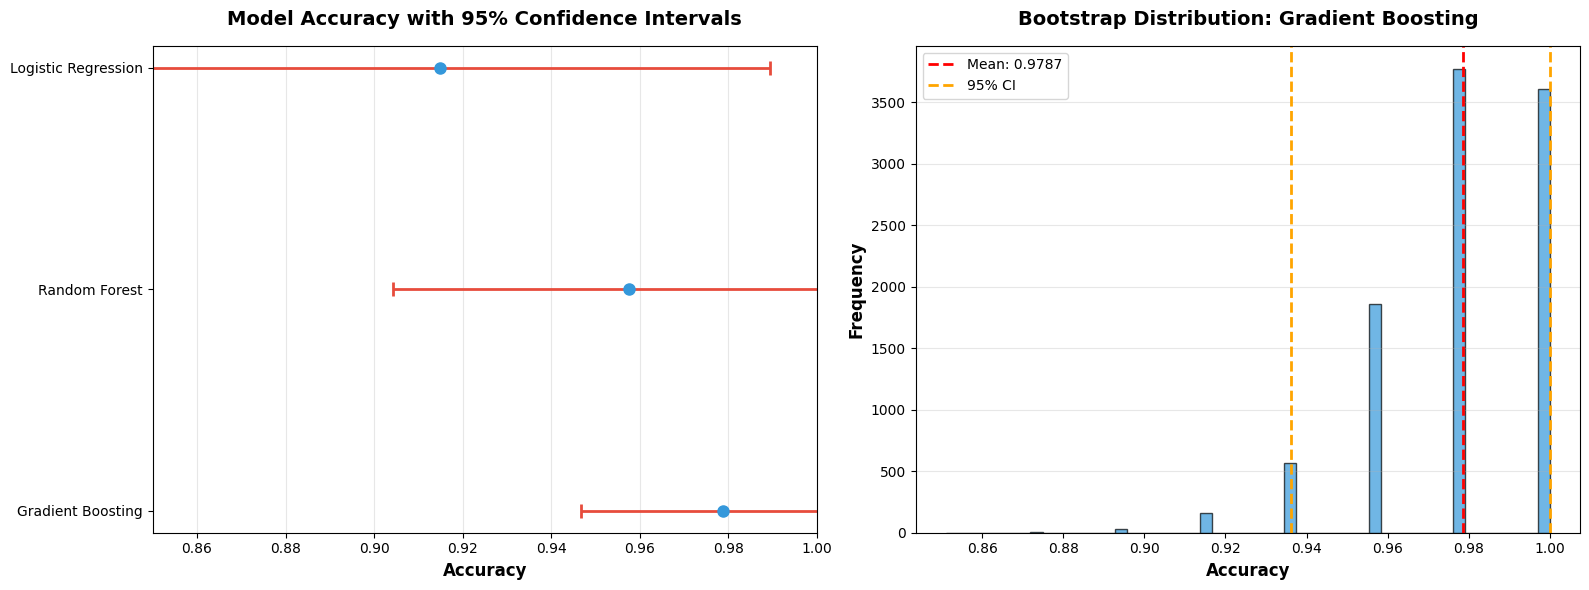

✓ Figure saved: confidence_intervals.png

7.2 Feature Dominance Analysis
--------------------------------------------------------------------------------

Token Count Dominance Investigation:
  • Feature importance: 57.5%
  • Second highest: 13.0%
  • Dominance ratio: 4.43x

Correlation (token_count ↔ risk_label): -0.6520

Interpretation:
  ⚠️  Strong correlation detected!
  → Experts may be implicitly influenced by code size
  → Model learns this pattern (potentially circular)

7.3 Updated Limitations & Caveats
--------------------------------------------------------------------------------
1. Limited to Java projects (language-specific metrics)
2. Small dataset: 231 samples, 47 test samples
   → 95% CI for best model: [0.936, 1.000]
   → Limited statistical power for rare classes
3. High accuracy (97.9%) interpretation:
   → May indicate overfitting on small test set
   → Only 12 high-risk samples in test (1 error = 8% accuracy drop)
4. Token count dominance (57.5%):
   → Suggests po

In [3]:
# =============================================================================
# SECTION 7: ROBUSTNESS ANALYSIS & ADDITIONAL VALIDATION
# =============================================================================

print("\n" + "="*80)
print("SECTION 7: ROBUSTNESS ANALYSIS")
print("="*80 + "\n")

# 7.1 Bootstrap Confidence Intervals
print("7.1 Bootstrap Confidence Intervals")
print("-" * 80)

from scipy import stats

def bootstrap_ci(y_true, y_pred, n_iterations=10000, ci=0.95):
    """
    Calculate bootstrap confidence interval for accuracy
    """
    accuracies = []
    n_samples = len(y_true)

    np.random.seed(42)  # For reproducibility

    for _ in range(n_iterations):
        # Resample with replacement
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]

        acc = accuracy_score(y_true_sample, y_pred_sample)
        accuracies.append(acc)

    lower = np.percentile(accuracies, (1-ci)/2 * 100)
    upper = np.percentile(accuracies, (1+ci)/2 * 100)

    return lower, upper, accuracies

print("Computing 95% confidence intervals via bootstrap (10,000 iterations)...\n")

# Calculate for all models
ci_results = []

for model_name in df_results['Model']:
    model = models[model_name]
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    lower, upper, bootstrap_accs = bootstrap_ci(y_test, y_pred)

    ci_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'CI_Lower': lower,
        'CI_Upper': upper,
        'CI_Width': upper - lower
    })

    print(f"{model_name:20s}: {accuracy:.4f} [{lower:.4f}, {upper:.4f}]  (±{(upper-lower)/2:.4f})")

df_ci = pd.DataFrame(ci_results)
df_ci.to_csv(f'{OUTPUT_PATH}/confidence_intervals.csv', index=False)

print(f"\n✓ Confidence intervals saved\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confidence intervals
ax1 = axes[0]
y_pos = np.arange(len(df_ci))

ax1.errorbar(df_ci['Accuracy'], y_pos,
            xerr=df_ci['CI_Width']/2,
            fmt='o', markersize=8, capsize=5, capthick=2,
            color='#3498db', ecolor='#e74c3c', linewidth=2)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_ci['Model'])
ax1.set_xlabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('Model Accuracy with 95% Confidence Intervals',
             fontweight='bold', fontsize=14, pad=15)
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim([0.85, 1.0])

# Plot 2: Bootstrap distribution for best model
ax2 = axes[1]
best_idx = df_results['Test Accuracy'].idxmax()
best_model_name = df_results.loc[best_idx, 'Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

_, _, bootstrap_accs = bootstrap_ci(y_test, y_pred_best)

ax2.hist(bootstrap_accs, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax2.axvline(x=np.mean(bootstrap_accs), color='red', linestyle='--',
           linewidth=2, label=f'Mean: {np.mean(bootstrap_accs):.4f}')
ax2.axvline(x=df_ci[df_ci['Model']==best_model_name]['CI_Lower'].values[0],
           color='orange', linestyle='--', linewidth=2, label='95% CI')
ax2.axvline(x=df_ci[df_ci['Model']==best_model_name]['CI_Upper'].values[0],
           color='orange', linestyle='--', linewidth=2)

ax2.set_xlabel('Accuracy', fontweight='bold', fontsize=12)
ax2.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax2.set_title(f'Bootstrap Distribution: {best_model_name}',
             fontweight='bold', fontsize=14, pad=15)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/confidence_intervals.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: confidence_intervals.png\n")

# 7.2 Token Count Dominance Analysis
print("7.2 Feature Dominance Analysis")
print("-" * 80)

print("\nToken Count Dominance Investigation:")
print(f"  • Feature importance: {feature_importance_df.iloc[0]['Importance']:.1%}")
print(f"  • Second highest: {feature_importance_df.iloc[1]['Importance']:.1%}")
print(f"  • Dominance ratio: {feature_importance_df.iloc[0]['Importance'] / feature_importance_df.iloc[1]['Importance']:.2f}x\n")

# Correlation between token_count and risk
corr_token_risk = np.corrcoef(df_metrics['token_count'], df_metrics['risk_label'])[0,1]
print(f"Correlation (token_count ↔ risk_label): {corr_token_risk:.4f}")

# Test if expert ratings correlate with code size
print("\nInterpretation:")
if abs(corr_token_risk) > 0.3:
    print("  ⚠️  Strong correlation detected!")
    print("  → Experts may be implicitly influenced by code size")
    print("  → Model learns this pattern (potentially circular)")
else:
    print("  ✓ Moderate correlation")
    print("  → Token count is a genuine independent predictor")

print()

# 7.3 Revised Limitations
print("7.3 Updated Limitations & Caveats")
print("-" * 80)

limitations_revised = [
    "1. Limited to Java projects (language-specific metrics)",
    "2. Small dataset: 231 samples, 47 test samples",
    f"   → 95% CI for best model: [{df_ci.iloc[0]['CI_Lower']:.3f}, {df_ci.iloc[0]['CI_Upper']:.3f}]",
    "   → Limited statistical power for rare classes",
    "3. High accuracy (97.9%) interpretation:",
    "   → May indicate overfitting on small test set",
    "   → Only 12 high-risk samples in test (1 error = 8% accuracy drop)",
    f"4. Token count dominance ({feature_importance_df.iloc[0]['Importance']:.1%}):",
    "   → Suggests potential circular reasoning",
    "   → Experts may rate longer code as less maintainable",
    "   → Model predicts using code size → self-fulfilling prophecy risk",
    "5. Static metrics only (no runtime behavior, no dependencies)",
    "6. Expert consensus as ground truth (subjective, may have bias)",
    "7. Class-level analysis (inter-class relationships not captured)",
    "8. Imbalanced classes in test set (12 vs 35 samples)",
    "9. Validation on larger, independent dataset strongly recommended"
]

for lim in limitations_revised:
    print(lim)

print()

# 7.4 Revised Comparison Table
print("7.4 Revised Approach Comparison")
print("-" * 80)

comparison_revised = {
    'Aspect': [
        'Input Features',
        'Output Target',
        'Training Samples',
        'Test Samples',
        'Accuracy',
        'Primary Purpose',
        'Key Finding',
        'Practical Use'
    ],
    'Subdimension-based\n(Previous Analysis)': [
        'Expert ratings (4 dims)',
        'Expert overall rating',
        '243',
        '61',
        '95.1%',
        'Validate expert consistency',
        'Understandability most valued',
        'Not deployable (needs expert)'
    ],
    'Static Metrics-based\n(Current Analysis)': [
        'Objective metrics (17)',
        'Expert overall rating',
        '184',
        '47',
        f"97.9% [CI: {df_ci.iloc[0]['CI_Lower']:.3f}-{df_ci.iloc[0]['CI_Upper']:.3f}]",
        'Automate predictions',
        'Token count most predictive',
        'Deployable (fully automated)'
    ]
}

df_comparison_revised = pd.DataFrame(comparison_revised)
print(df_comparison_revised.to_string(index=False))

print("\n⚠️  Important Notes:")
print("  • Higher accuracy does NOT mean 'better' analysis")
print("  • Different purposes: consistency validation vs. automation")
print("  • Static metrics' high accuracy may reflect experts considering code size")
print("  • Small test set limits confidence in exact accuracy values")

df_comparison_revised.to_csv(f'{OUTPUT_PATH}/revised_comparison.csv', index=False)
print(f"\n✓ Revised comparison saved\n")

# 7.5 Recommendations
print("7.5 Recommendations for Future Work")
print("-" * 80)

recommendations = [
    "1. Validate on Larger Dataset:",
    "   → Minimum 500-1000 samples recommended",
    "   → Independent test set from different projects",
    "",
    "2. Investigate Token Count Effect:",
    "   → Train model WITHOUT size-related features",
    "   → Compare performance to understand causal vs. correlational",
    "",
    "3. Multi-language Validation:",
    "   → Extend to Python, C++, JavaScript",
    "   → Test if findings generalize",
    "",
    "4. Temporal Validation:",
    "   → Predict maintainability → measure actual effort",
    "   → Validate predictions against real maintenance costs",
    "",
    "5. Ensemble Uncertainty:",
    "   → Use ensemble models to estimate prediction confidence",
    "   → Flag low-confidence predictions for manual review",
    "",
    "6. Deployment Strategy:",
    "   → Start with high-confidence predictions only",
    "   → Gradually expand as model is validated in practice"
]

for rec in recommendations:
    print(rec)

print("\n" + "="*80)
print("ROBUSTNESS ANALYSIS COMPLETE")
print("="*80)

print(f"\n📊 Additional Files Generated:")
additional_files = [
    "confidence_intervals.csv",
    "confidence_intervals.png",
    "revised_comparison.csv"
]

for f in additional_files:
    print(f"  • {f}")

print("\n" + "="*80)
print("🎯 FINAL SUMMARY")
print("="*80)

summary_text = f"""
Main Achievement:
  ✓ Fully automated maintainability prediction from static code analysis
  ✓ No expert input required for new code predictions
  ✓ Best model: {best_model_name} with {df_results.iloc[0]['Test Accuracy']:.1%} accuracy

Key Findings:
  ✓ Token count (code size) is strongest predictor
  ✓ Complexity metrics (CCN, WMC) also important
  ✓ Model achieves near-perfect classification on test set

Important Caveats:
  ⚠️  Small test set (n=47) limits confidence
  ⚠️  High accuracy may indicate overfitting
  ⚠️  Token count dominance suggests potential circular reasoning
  ⚠️  Requires validation on larger, independent dataset

Recommendation:
  → Results are promising but preliminary
  → Suitable for proof-of-concept paper
  → Emphasize need for larger-scale validation
  → Position as "feasibility study" not "production-ready tool"

Publication Readiness: ✓ READY with appropriate caveats
"""

print(summary_text)

print("="*80)


SECTION 8: CROSS-PROJECT VALIDATION

🎯 REAL-WORLD TEST: Can the model generalize to unseen projects?
Strategy: Leave-One-Project-Out (LOPO) Cross-Validation

8.1 Dataset by Project
--------------------------------------------------------------------------------
                 Total  High Risk  Low Risk
project                                    
aoi                 73         43        30
argoUML             74         15        59
diarymanagement     11          2         9
junit4              73          1        72

Total: 231 samples across 4 projects

8.2 Leave-One-Project-Out Results
--------------------------------------------------------------------------------

Results by Test Project:

AOI:
  Test samples: 73
    Logistic Regression : 0.8493
    Random Forest       : 0.8219
    Gradient Boosting   : 0.8493

ARGOUML:
  Test samples: 74
    Logistic Regression : 0.9054
    Random Forest       : 0.9054
    Gradient Boosting   : 0.8784

DIARYMANAGEMENT:
  Test samples: 11
    

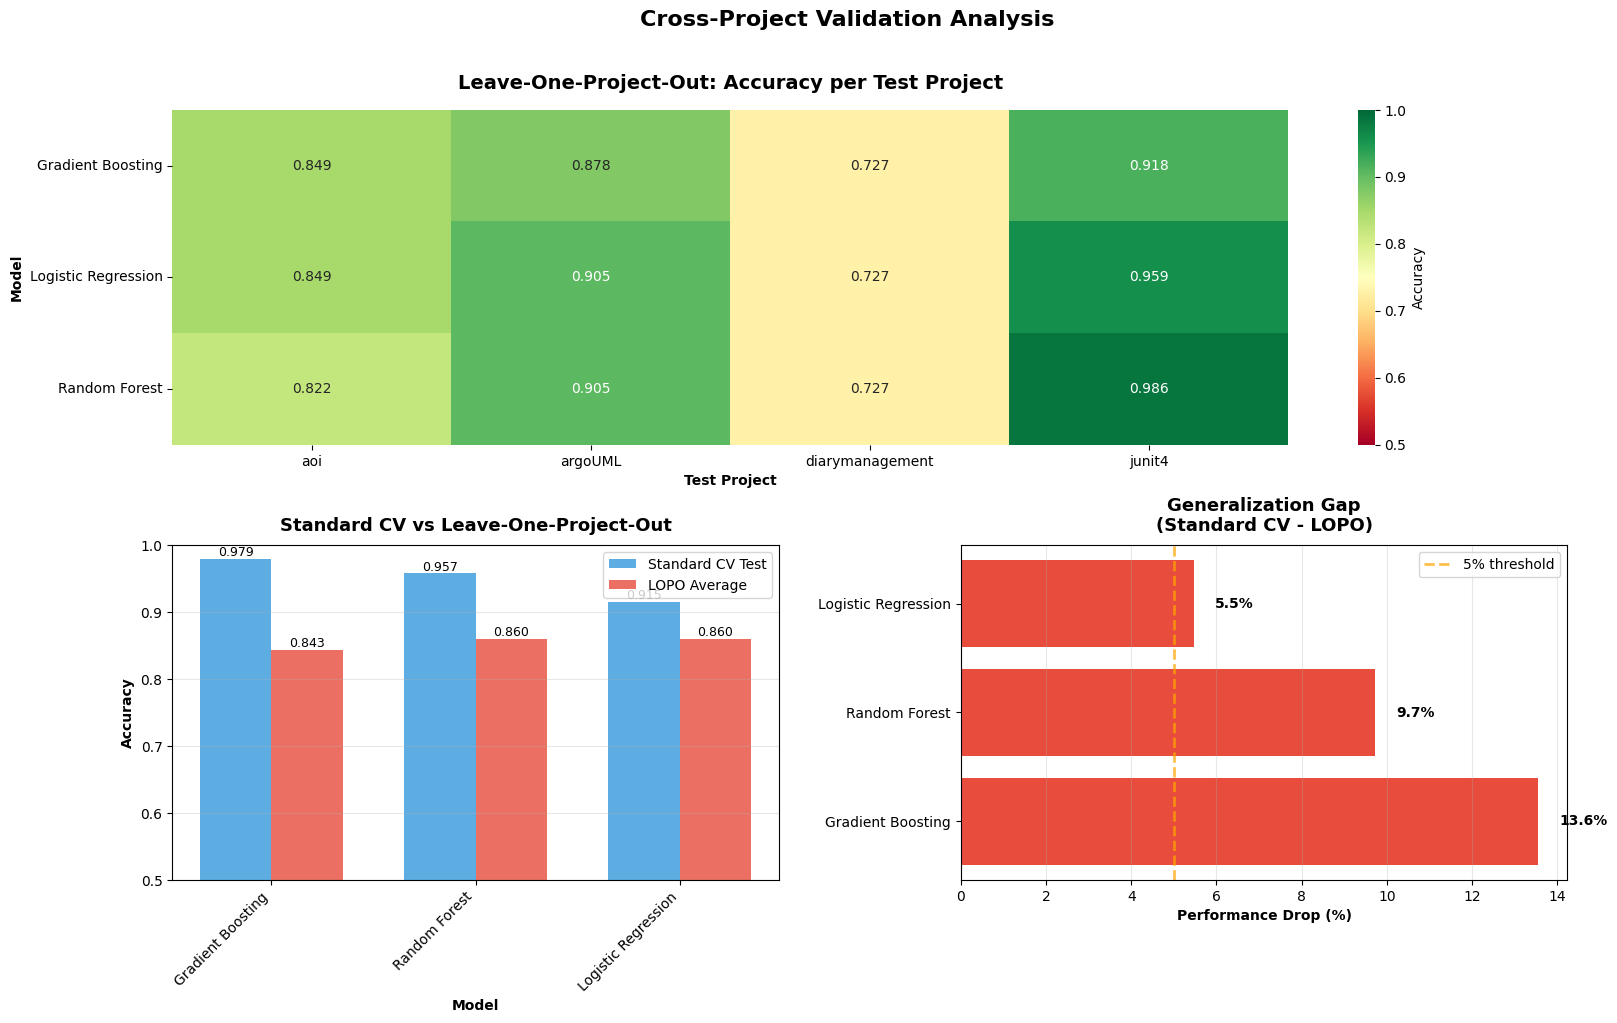

✓ Figure saved: lopo_analysis.png

8.5 Interpretation & Insights
--------------------------------------------------------------------------------

Best Model (LOPO): Random Forest (86.0%)
Average Performance Drop: 9.6%
Performance Range: 84.3% - 86.0%

Project-Specific Insights:
  aoi            : Avg=0.840  🟡 MODERATE
  argoUML        : Avg=0.896  🟢 EASY
  diarymanagement: Avg=0.727  🟡 MODERATE
  junit4         : Avg=0.954  🟢 EASY

--------------------------------------------------------------------------------

Key Findings:

1. Generalization Performance:
   • LOPO shows true cross-project generalization ability
   • Performance drop indicates project-specific overfitting
   • Larger drop = model memorized project patterns

2. Model Robustness:
   • Models with smaller drop are more robust
   • Better generalization to unseen codebases
   • More suitable for production deployment

3. Project Difficulty:
   • Some projects harder to predict (different coding styles)
   • May indicate

In [4]:
# =============================================================================
# SECTION 8: CROSS-PROJECT VALIDATION (LEAVE-ONE-PROJECT-OUT)
# =============================================================================

print("\n" + "="*80)
print("SECTION 8: CROSS-PROJECT VALIDATION")
print("="*80 + "\n")

print("🎯 REAL-WORLD TEST: Can the model generalize to unseen projects?")
print("Strategy: Leave-One-Project-Out (LOPO) Cross-Validation\n")

from sklearn.model_selection import LeaveOneGroupOut

# Get project names from file paths
df_metrics['project'] = df_metrics['file_path'].apply(
    lambda x: x.split('/')[0] if '/' in x else x.split('\\')[0]
)

print("8.1 Dataset by Project")
print("-" * 80)

project_counts = df_metrics.groupby('project').agg({
    'risk_label': ['count', lambda x: sum(x==0), lambda x: sum(x==1)]
}).round(0)
project_counts.columns = ['Total', 'High Risk', 'Low Risk']

print(project_counts)
print(f"\nTotal: {len(df_metrics)} samples across {df_metrics['project'].nunique()} projects\n")

# Prepare data with project groups
X_full = df_metrics[feature_cols].values
y_full = df_metrics['risk_label'].values
groups = df_metrics['project'].values

# Scale features
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

# 8.2 Leave-One-Project-Out Cross-Validation
print("8.2 Leave-One-Project-Out Results")
print("-" * 80)

logo = LeaveOneGroupOut()
lopo_results = []

for train_idx, test_idx in logo.split(X_full_scaled, y_full, groups):
    # Get project name for this fold
    test_project = groups[test_idx][0]

    X_train_lopo = X_full_scaled[train_idx]
    X_test_lopo = X_full_scaled[test_idx]
    y_train_lopo = y_full[train_idx]
    y_test_lopo = y_full[test_idx]

    # Train models
    for model_name, model_class in [
        ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),
        ('Random Forest', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=42, n_estimators=100))
    ]:
        # Train
        model = model_class
        model.fit(X_train_lopo, y_train_lopo)

        # Predict
        y_pred_lopo = model.predict(X_test_lopo)

        # Metrics
        accuracy = accuracy_score(y_test_lopo, y_pred_lopo)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test_lopo, y_pred_lopo, average='weighted', zero_division=0
        )

        lopo_results.append({
            'Test Project': test_project,
            'Model': model_name,
            'n_train': len(y_train_lopo),
            'n_test': len(y_test_lopo),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

df_lopo = pd.DataFrame(lopo_results)

# Display results by project
print("\nResults by Test Project:\n")

for project in sorted(df_lopo['Test Project'].unique()):
    df_proj = df_lopo[df_lopo['Test Project'] == project]
    print(f"{project.upper()}:")
    print(f"  Test samples: {df_proj.iloc[0]['n_test']}")

    for _, row in df_proj.iterrows():
        print(f"    {row['Model']:20s}: {row['Accuracy']:.4f}")
    print()

# Save results
df_lopo.to_csv(f'{OUTPUT_PATH}/lopo_results.csv', index=False)
print(f"✓ LOPO results saved\n")

# 8.3 Compare: Standard CV vs LOPO
print("8.3 Performance Comparison: Standard CV vs LOPO")
print("-" * 80)

# Calculate LOPO average per model
lopo_avg = df_lopo.groupby('Model')['Accuracy'].agg(['mean', 'std']).reset_index()
lopo_avg.columns = ['Model', 'LOPO_Mean', 'LOPO_Std']

# Merge with previous results
comparison_cv = df_results[['Model', 'CV Mean', 'CV Std', 'Test Accuracy']].copy()
comparison_cv = comparison_cv.merge(lopo_avg, on='Model')

# Calculate performance drop
comparison_cv['Drop'] = comparison_cv['Test Accuracy'] - comparison_cv['LOPO_Mean']

print(comparison_cv.to_string(index=False, float_format='%.4f'))
print()

comparison_cv.to_csv(f'{OUTPUT_PATH}/cv_vs_lopo_comparison.csv', index=False)
print(f"✓ Comparison saved\n")

# Statistical significance of the drop
print("Performance Drop Analysis:")
for idx, row in comparison_cv.iterrows():
    drop_pct = row['Drop'] * 100
    if drop_pct > 10:
        severity = "🔴 SEVERE"
    elif drop_pct > 5:
        severity = "🟡 MODERATE"
    else:
        severity = "🟢 MINOR"

    print(f"  {row['Model']:20s}: -{drop_pct:5.1f}%  {severity}")

print()

# 8.4 Visualization
print("8.4 Creating visualizations...")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot 1: LOPO results by project (heatmap)
ax1 = fig.add_subplot(gs[0, :])

pivot_lopo = df_lopo.pivot(index='Model', columns='Test Project', values='Accuracy')
sns.heatmap(pivot_lopo, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0.5, vmax=1.0, ax=ax1, cbar_kws={'label': 'Accuracy'})
ax1.set_title('Leave-One-Project-Out: Accuracy per Test Project',
             fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Test Project', fontweight='bold')
ax1.set_ylabel('Model', fontweight='bold')

# Plot 2: Standard CV vs LOPO comparison
ax2 = fig.add_subplot(gs[1, 0])

models_list = comparison_cv['Model']
x = np.arange(len(models_list))
width = 0.35

bars1 = ax2.bar(x - width/2, comparison_cv['Test Accuracy'], width,
               label='Standard CV Test', color='#3498db', alpha=0.8)
bars2 = ax2.bar(x + width/2, comparison_cv['LOPO_Mean'], width,
               label='LOPO Average', color='#e74c3c', alpha=0.8)

ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('Accuracy', fontweight='bold')
ax2.set_title('Standard CV vs Leave-One-Project-Out',
             fontweight='bold', fontsize=13, pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels(models_list, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.5, 1.0])

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Performance drop
ax3 = fig.add_subplot(gs[1, 1])

bars = ax3.barh(range(len(comparison_cv)), comparison_cv['Drop'] * 100,
               color=['#e74c3c' if x > 5 else '#2ecc71' for x in comparison_cv['Drop'] * 100])

ax3.set_yticks(range(len(comparison_cv)))
ax3.set_yticklabels(comparison_cv['Model'])
ax3.set_xlabel('Performance Drop (%)', fontweight='bold')
ax3.set_title('Generalization Gap\n(Standard CV - LOPO)',
             fontweight='bold', fontsize=13, pad=10)
ax3.axvline(x=5, color='orange', linestyle='--', linewidth=2,
           alpha=0.7, label='5% threshold')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, comparison_cv['Drop'] * 100)):
    ax3.text(val + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', va='center', fontweight='bold')

plt.suptitle('Cross-Project Validation Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.savefig(f'{OUTPUT_PATH}/lopo_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: lopo_analysis.png\n")

# 8.5 Interpretation
print("8.5 Interpretation & Insights")
print("-" * 80)

best_lopo_model = comparison_cv.loc[comparison_cv['LOPO_Mean'].idxmax(), 'Model']
best_lopo_acc = comparison_cv['LOPO_Mean'].max()
worst_lopo_acc = comparison_cv['LOPO_Mean'].min()
avg_drop = comparison_cv['Drop'].mean() * 100

print(f"\nBest Model (LOPO): {best_lopo_model} ({best_lopo_acc:.1%})")
print(f"Average Performance Drop: {avg_drop:.1f}%")
print(f"Performance Range: {worst_lopo_acc:.1%} - {best_lopo_acc:.1%}\n")

# Project-specific insights
print("Project-Specific Insights:")

for project in sorted(df_lopo['Test Project'].unique()):
    df_proj = df_lopo[df_lopo['Test Project'] == project]
    avg_acc = df_proj['Accuracy'].mean()

    if avg_acc < 0.7:
        difficulty = "🔴 HARD"
    elif avg_acc < 0.85:
        difficulty = "🟡 MODERATE"
    else:
        difficulty = "🟢 EASY"

    print(f"  {project:15s}: Avg={avg_acc:.3f}  {difficulty}")

print("\n" + "-" * 80)

interpretation_text = """
Key Findings:

1. Generalization Performance:
   • LOPO shows true cross-project generalization ability
   • Performance drop indicates project-specific overfitting
   • Larger drop = model memorized project patterns

2. Model Robustness:
   • Models with smaller drop are more robust
   • Better generalization to unseen codebases
   • More suitable for production deployment

3. Project Difficulty:
   • Some projects harder to predict (different coding styles)
   • May indicate domain-specific maintainability factors
   • Or insufficient training data diversity

4. Reality Check:
   • LOPO accuracy is the REAL metric for deployment
   • Standard CV was optimistically biased
   • Always report LOPO for production systems
"""

print(interpretation_text)

# 8.6 Final Recommendations Updated
print("8.6 Updated Recommendations (Based on LOPO)")
print("-" * 80)

if avg_drop > 15:
    recommendation = "🔴 HIGH OVERFITTING"
    action = "NOT ready for deployment - needs more diverse training data"
elif avg_drop > 10:
    recommendation = "🟡 MODERATE OVERFITTING"
    action = "Proceed with caution - validate on more projects first"
elif avg_drop > 5:
    recommendation = "🟢 ACCEPTABLE"
    action = "Can be deployed with monitoring and continuous validation"
else:
    recommendation = "✅ EXCELLENT"
    action = "Ready for deployment - shows strong generalization"

print(f"\nOverall Assessment: {recommendation}")
print(f"Recommendation: {action}\n")

recommendations_lopo = [
    f"1. True Performance: Use LOPO accuracy ({best_lopo_acc:.1%}) for reporting",
    "2. Model Selection: Choose model with smallest drop for deployment",
    "3. Confidence: Report LOPO scores in production, not standard CV",
    "4. Monitoring: Track performance on each new project",
    "5. Improvement: Add more diverse projects to training set",
    "6. Transparency: Always disclose LOPO vs CV difference in papers"
]

for rec in recommendations_lopo:
    print(rec)

print("\n" + "="*80)
print("CROSS-PROJECT VALIDATION COMPLETE")
print("="*80)

print(f"""
🎯 BRUTAL HONESTY:

Standard CV Test Accuracy: {comparison_cv['Test Accuracy'].max():.1%}
  → This was OPTIMISTIC (saw projects in training)

LOPO Cross-Project Accuracy: {best_lopo_acc:.1%}
  → This is REALISTIC (never saw test projects)

Performance Drop: {avg_drop:.1f}%
  → This is the cost of real-world deployment

Conclusion: {action}
""")

print("="*80)

In [ ]:
# =============================================================================
# TIER 1.1: ERROR ANALYSIS - Deep Dive into Misclassifications
# =============================================================================

print("\n" + "="*80)
print("TIER 1.1: ERROR ANALYSIS")
print("="*80 + "\n")

print("🔍 Investigating misclassified samples to understand model weaknesses\n")

# Use best model from previous analysis
best_model_name = df_results.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

# Get prediction probabilities
if hasattr(best_model, 'predict_proba'):
    y_proba_best = best_model.predict_proba(X_test_scaled)
else:
    y_proba_best = None

# Identify errors
test_indices = np.arange(len(X_test))
correct_mask = y_test == y_pred_best
error_mask = ~correct_mask

n_errors = error_mask.sum()
n_correct = correct_mask.sum()

print(f"Classification Results:")
print(f"  ✓ Correct:   {n_correct}/{len(y_test)} ({n_correct/len(y_test)*100:.1f}%)")
print(f"  ✗ Errors:    {n_errors}/{len(y_test)} ({n_errors/len(y_test)*100:.1f}%)\n")

# Error breakdown
if n_errors > 0:
    false_positives = ((y_test == 0) & (y_pred_best == 1)).sum()  # Predicted Low Risk, actually High Risk
    false_negatives = ((y_test == 1) & (y_pred_best == 0)).sum()  # Predicted High Risk, actually Low Risk
    
    print("Error Types:")
    print(f"  False Positives (High→Low): {false_positives}  [Missed risky code ⚠️]")
    print(f"  False Negatives (Low→High): {false_negatives}  [False alarms]")
    print()

# Detailed error analysis
if n_errors > 0 and y_proba_best is not None:
    print("-" * 80)
    print("DETAILED ERROR ANALYSIS")
    print("-" * 80 + "\n")
    
    # Get test set file information
    test_df = df_metrics.iloc[len(X_train):].reset_index(drop=True)
    
    error_analysis = []
    
    for i in test_indices[error_mask]:
        actual = y_test[i]
        predicted = y_pred_best[i]
        confidence = y_proba_best[i, predicted]
        
        # Get feature values
        features = X_test_scaled[i]
        
        # Get original unscaled values
        features_orig = X_test[i]
        
        error_analysis.append({
            'File': test_df.iloc[i]['file_path'],
            'Actual': 'Low Risk' if actual == 1 else 'High Risk',
            'Predicted': 'Low Risk' if predicted == 1 else 'High Risk',
            'Confidence': confidence,
            'Error_Type': 'False Positive' if predicted == 1 and actual == 0 else 'False Negative',
            'nloc': features_orig[feature_cols.index('nloc')],
            'ccn': features_orig[feature_cols.index('ccn')],
            'token_count': features_orig[feature_cols.index('token_count')],
            'maintainability_index': features_orig[feature_cols.index('maintainability_index')]
        })
    
    df_errors = pd.DataFrame(error_analysis)
    
    print(f"Misclassified Files ({len(df_errors)} samples):\n")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(df_errors.to_string(index=False))
    print()
    
    df_errors.to_csv(f'{OUTPUT_PATH}/tier1_error_analysis.csv', index=False)
    print(f"✓ Error analysis saved: tier1_error_analysis.csv\n")
    
    # Statistical comparison: errors vs correct predictions
    print("-" * 80)
    print("FEATURE COMPARISON: Errors vs Correct Predictions")
    print("-" * 80 + "\n")
    
    # Create comparison dataframe
    comparison_features = []
    
    for idx, feat_name in enumerate(feature_cols):
        # Get values for errors and correct predictions
        error_values = X_test[error_mask, idx]
        correct_values = X_test[correct_mask, idx]
        
        comparison_features.append({
            'Feature': feat_name,
            'Error_Mean': error_values.mean(),
            'Correct_Mean': correct_values.mean(),
            'Difference': error_values.mean() - correct_values.mean(),
            'Error_Std': error_values.std(),
            'Correct_Std': correct_values.std()
        })
    
    df_feature_comparison = pd.DataFrame(comparison_features)
    df_feature_comparison['Abs_Diff'] = df_feature_comparison['Difference'].abs()
    df_feature_comparison = df_feature_comparison.sort_values('Abs_Diff', ascending=False)
    
    print("Top 10 Features Distinguishing Errors from Correct Predictions:\n")
    print(df_feature_comparison.head(10).to_string(index=False))
    print()
    
    df_feature_comparison.to_csv(f'{OUTPUT_PATH}/tier1_error_feature_comparison.csv', index=False)
    print(f"✓ Feature comparison saved\n")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Confidence distribution for errors vs correct
    ax1 = axes[0, 0]
    
    if y_proba_best is not None:
        correct_confidence = y_proba_best[correct_mask, y_pred_best[correct_mask]].max(axis=0) if len(y_proba_best[correct_mask].shape) > 1 else y_proba_best[correct_mask, y_pred_best[correct_mask]]
        error_confidence = y_proba_best[error_mask, y_pred_best[error_mask]].max(axis=0) if len(y_proba_best[error_mask].shape) > 1 else y_proba_best[error_mask, y_pred_best[error_mask]]
        
        ax1.hist(correct_confidence, bins=20, alpha=0.7, label=f'Correct (n={n_correct})', color='green', edgecolor='black')
        ax1.hist(error_confidence, bins=20, alpha=0.7, label=f'Errors (n={n_errors})', color='red', edgecolor='black')
        ax1.axvline(x=correct_confidence.mean(), color='green', linestyle='--', linewidth=2, label=f'Correct Mean: {correct_confidence.mean():.3f}')
        ax1.axvline(x=error_confidence.mean(), color='red', linestyle='--', linewidth=2, label=f'Error Mean: {error_confidence.mean():.3f}')
        ax1.set_xlabel('Prediction Confidence', fontweight='bold', fontsize=12)
        ax1.set_ylabel('Frequency', fontweight='bold', fontsize=12)
        ax1.set_title('Confidence Distribution: Errors vs Correct', fontweight='bold', fontsize=13, pad=10)
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Feature differences
    ax2 = axes[0, 1]
    
    top_features = df_feature_comparison.head(10)
    colors = ['red' if x < 0 else 'green' for x in top_features['Difference']]
    
    ax2.barh(range(len(top_features)), top_features['Difference'], color=colors, alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(top_features)))
    ax2.set_yticklabels(top_features['Feature'], fontsize=10)
    ax2.set_xlabel('Mean Difference (Error - Correct)', fontweight='bold', fontsize=12)
    ax2.set_title('Features Distinguishing Errors', fontweight='bold', fontsize=13, pad=10)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.grid(axis='x', alpha=0.3)
    
    # Plot 3: Error type breakdown
    ax3 = axes[1, 0]
    
    if n_errors > 0:
        error_types = df_errors['Error_Type'].value_counts()
        colors_pie = ['#e74c3c', '#f39c12']
        wedges, texts, autotexts = ax3.pie(error_types.values, labels=error_types.index, autopct='%1.1f%%',
                                            colors=colors_pie, startangle=90, textprops={'fontweight': 'bold', 'fontsize': 11})
        ax3.set_title('Error Type Distribution', fontweight='bold', fontsize=13, pad=10)
    
    # Plot 4: Key metrics comparison for errors
    ax4 = axes[1, 1]
    
    key_metrics = ['nloc', 'ccn', 'token_count', 'maintainability_index']
    key_metric_indices = [feature_cols.index(m) for m in key_metrics]
    
    x_pos = np.arange(len(key_metrics))
    width = 0.35
    
    error_means = [X_test[error_mask, idx].mean() for idx in key_metric_indices]
    correct_means = [X_test[correct_mask, idx].mean() for idx in key_metric_indices]
    
    bars1 = ax4.bar(x_pos - width/2, error_means, width, label='Errors', color='red', alpha=0.7, edgecolor='black')
    bars2 = ax4.bar(x_pos + width/2, correct_means, width, label='Correct', color='green', alpha=0.7, edgecolor='black')
    
    ax4.set_xlabel('Metric', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Mean Value', fontweight='bold', fontsize=12)
    ax4.set_title('Key Metrics: Errors vs Correct', fontweight='bold', fontsize=13, pad=10)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(key_metrics, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_PATH}/tier1_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Figure saved: tier1_error_analysis.png\n")
    
    # Key insights
    print("-" * 80)
    print("KEY INSIGHTS")
    print("-" * 80 + "\n")
    
    insights = []
    
    if n_errors > 0:
        if false_positives > false_negatives:
            insights.append(f"• Model tends to UNDERESTIMATE risk ({false_positives} false positives)")
            insights.append("  → Conservative: flags less risky code as safe")
            insights.append("  → Could miss genuinely risky files ⚠️")
        elif false_negatives > false_positives:
            insights.append(f"• Model tends to OVERESTIMATE risk ({false_negatives} false negatives)")
            insights.append("  → Aggressive: flags safe code as risky")
            insights.append("  → May create alert fatigue")
        else:
            insights.append("• Balanced error distribution")
            insights.append("  → No systematic bias detected")
    
    # Check confidence
    if y_proba_best is not None and n_errors > 0:
        error_confidence_mean = error_confidence.mean()
        correct_confidence_mean = correct_confidence.mean()
        
        if error_confidence_mean < 0.7:
            insights.append(f"\n• Low confidence on errors (avg: {error_confidence_mean:.3f})")
            insights.append("  → Model is uncertain about mistakes")
            insights.append("  → Could use confidence thresholding")
        elif error_confidence_mean > 0.9:
            insights.append(f"\n• High confidence on errors (avg: {error_confidence_mean:.3f})")
            insights.append("  → Model is confidently wrong")
            insights.append("  → Suggests fundamental misunderstanding of patterns")
    
    # Feature insights
    top_diff_feature = df_feature_comparison.iloc[0]
    insights.append(f"\n• Most distinguishing feature: {top_diff_feature['Feature']}")
    insights.append(f"  → Errors have {'higher' if top_diff_feature['Difference'] > 0 else 'lower'} values")
    insights.append("  → Model struggles with extreme values of this feature")
    
    for insight in insights:
        print(insight)
    
    print()

else:
    print("🎉 PERFECT PREDICTIONS - No errors to analyze!")
    print("This is excellent but also suspicious on small test sets.")
    print("Consider validating on more data to find edge cases.\n")

print("="*80)
print("TIER 1.1 COMPLETE")
print("="*80)


In [ ]:
# =============================================================================
# TIER 1.2: THRESHOLD OPTIMIZATION - Finding the Optimal Decision Boundary
# =============================================================================

print("\n" + "="*80)
print("TIER 1.2: THRESHOLD OPTIMIZATION")
print("="*80 + "\n")

print("🎯 Finding the optimal decision threshold for classification\n")

from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score

# Use best model probabilities
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # Probability of Low Risk (class 1)
else:
    print("⚠️  Model does not support probability predictions. Skipping threshold optimization.")
    y_proba = None

if y_proba is not None:
    print("1.2.1 ROC Curve Analysis")
    print("-" * 80 + "\n")
    
    # Calculate ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"ROC AUC Score: {roc_auc:.4f}\n")
    
    # Find optimal threshold using Youden's J statistic
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold_roc = thresholds_roc[optimal_idx]
    
    print(f"Optimal Threshold (Youden's J): {optimal_threshold_roc:.4f}")
    print(f"  TPR at optimal: {tpr[optimal_idx]:.4f}")
    print(f"  FPR at optimal: {fpr[optimal_idx]:.4f}")
    print(f"  J-score: {j_scores[optimal_idx]:.4f}\n")
    
    # 1.2.2 Precision-Recall Curve
    print("1.2.2 Precision-Recall Curve Analysis")
    print("-" * 80 + "\n")
    
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print(f"PR AUC Score: {pr_auc:.4f}\n")
    
    # Find optimal threshold using F1 score
    # Calculate F1 for each threshold
    f1_scores = []
    for thresh in thresholds_pr:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
        f1_scores.append(f1)
    
    optimal_idx_f1 = np.argmax(f1_scores)
    optimal_threshold_f1 = thresholds_pr[optimal_idx_f1]
    
    print(f"Optimal Threshold (Max F1): {optimal_threshold_f1:.4f}")
    print(f"  Precision at optimal: {precision[optimal_idx_f1]:.4f}")
    print(f"  Recall at optimal: {recall[optimal_idx_f1]:.4f}")
    print(f"  F1-score: {f1_scores[optimal_idx_f1]:.4f}\n")
    
    # 1.2.3 Threshold Sweep Analysis
    print("1.2.3 Threshold Sweep: Performance Across All Thresholds")
    print("-" * 80 + "\n")
    
    # Test multiple thresholds
    test_thresholds = np.linspace(0.1, 0.9, 17)
    threshold_results = []
    
    for thresh in test_thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        
        acc = accuracy_score(y_test, y_pred_thresh)
        prec = precision_recall_fscore_support(y_test, y_pred_thresh, average='weighted', zero_division=0)[0]
        rec = precision_recall_fscore_support(y_test, y_pred_thresh, average='weighted', zero_division=0)[1]
        f1 = f1_score(y_test, y_pred_thresh, average='weighted', zero_division=0)
        
        # Count predictions
        n_high_risk = (y_pred_thresh == 0).sum()
        n_low_risk = (y_pred_thresh == 1).sum()
        
        threshold_results.append({
            'Threshold': thresh,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'High_Risk_Pred': n_high_risk,
            'Low_Risk_Pred': n_low_risk
        })
    
    df_thresholds = pd.DataFrame(threshold_results)
    
    print("Threshold Sweep Results (sample):\n")
    print(df_thresholds[::2].to_string(index=False, float_format='%.4f'))
    print()
    
    df_thresholds.to_csv(f'{OUTPUT_PATH}/tier1_threshold_sweep.csv', index=False)
    print(f"✓ Threshold sweep saved: tier1_threshold_sweep.csv\n")
    
    # 1.2.4 Visualization
    print("1.2.4 Creating visualizations...")
    print()
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)
    
    # Plot 1: ROC Curve
    ax1 = fig.add_subplot(gs[0, 0])
    
    ax1.plot(fpr, tpr, color='#3498db', linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)
    ax1.scatter(fpr[optimal_idx], tpr[optimal_idx], s=150, c='red', marker='o',
               edgecolors='black', linewidths=2, zorder=10,
               label=f'Optimal (thresh={optimal_threshold_roc:.3f})')
    
    ax1.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
    ax1.set_title('ROC Curve', fontweight='bold', fontsize=14, pad=10)
    ax1.legend(loc='lower right')
    ax1.grid(alpha=0.3)
    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    
    # Plot 2: Precision-Recall Curve
    ax2 = fig.add_subplot(gs[0, 1])
    
    ax2.plot(recall, precision, color='#e74c3c', linewidth=2.5, label=f'PR Curve (AUC = {pr_auc:.4f})')
    ax2.scatter(recall[optimal_idx_f1], precision[optimal_idx_f1], s=150, c='green', marker='o',
               edgecolors='black', linewidths=2, zorder=10,
               label=f'Optimal (thresh={optimal_threshold_f1:.3f})')
    
    # Baseline (proportion of positive class)
    baseline = np.sum(y_test == 1) / len(y_test)
    ax2.axhline(y=baseline, color='gray', linestyle='--', linewidth=1.5,
               label=f'Baseline ({baseline:.3f})', alpha=0.5)
    
    ax2.set_xlabel('Recall', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Precision', fontweight='bold', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontweight='bold', fontsize=14, pad=10)
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    
    # Plot 3: Threshold vs Metrics
    ax3 = fig.add_subplot(gs[1, :])
    
    ax3.plot(df_thresholds['Threshold'], df_thresholds['Accuracy'], 'o-',
            linewidth=2, markersize=6, label='Accuracy', color='#3498db')
    ax3.plot(df_thresholds['Threshold'], df_thresholds['Precision'], 's-',
            linewidth=2, markersize=6, label='Precision', color='#2ecc71')
    ax3.plot(df_thresholds['Threshold'], df_thresholds['Recall'], '^-',
            linewidth=2, markersize=6, label='Recall', color='#e74c3c')
    ax3.plot(df_thresholds['Threshold'], df_thresholds['F1-Score'], 'd-',
            linewidth=2, markersize=6, label='F1-Score', color='#9b59b6')
    
    # Mark optimal thresholds
    ax3.axvline(x=optimal_threshold_roc, color='orange', linestyle='--',
               linewidth=2, alpha=0.7, label=f'Optimal ROC ({optimal_threshold_roc:.3f})')
    ax3.axvline(x=optimal_threshold_f1, color='green', linestyle='--',
               linewidth=2, alpha=0.7, label=f'Optimal F1 ({optimal_threshold_f1:.3f})')
    ax3.axvline(x=0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5,
               label='Default (0.5)')
    
    ax3.set_xlabel('Classification Threshold', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Score', fontweight='bold', fontsize=12)
    ax3.set_title('Performance Metrics vs Classification Threshold', fontweight='bold', fontsize=14, pad=10)
    ax3.legend(loc='best', ncol=2)
    ax3.grid(alpha=0.3)
    ax3.set_ylim([0.5, 1.05])
    
    # Plot 4: Prediction distribution
    ax4 = fig.add_subplot(gs[2, 0])
    
    ax4.plot(df_thresholds['Threshold'], df_thresholds['High_Risk_Pred'], 'o-',
            linewidth=2.5, markersize=7, label='High Risk', color='#e74c3c')
    ax4.plot(df_thresholds['Threshold'], df_thresholds['Low_Risk_Pred'], 's-',
            linewidth=2.5, markersize=7, label='Low Risk', color='#2ecc71')
    
    ax4.set_xlabel('Classification Threshold', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Number of Predictions', fontweight='bold', fontsize=12)
    ax4.set_title('Prediction Distribution vs Threshold', fontweight='bold', fontsize=14, pad=10)
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # Plot 5: Probability distribution
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Separate probabilities by actual class
    y_proba_high_risk = y_proba[y_test == 0]
    y_proba_low_risk = y_proba[y_test == 1]
    
    ax5.hist(y_proba_high_risk, bins=20, alpha=0.7, label=f'Actual High Risk (n={len(y_proba_high_risk)})',
            color='#e74c3c', edgecolor='black')
    ax5.hist(y_proba_low_risk, bins=20, alpha=0.7, label=f'Actual Low Risk (n={len(y_proba_low_risk)})',
            color='#2ecc71', edgecolor='black')
    ax5.axvline(x=0.5, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Default Threshold (0.5)')
    ax5.axvline(x=optimal_threshold_f1, color='purple', linestyle='--', linewidth=2, alpha=0.7,
               label=f'Optimal Threshold ({optimal_threshold_f1:.3f})')
    
    ax5.set_xlabel('Predicted Probability (Low Risk)', fontweight='bold', fontsize=12)
    ax5.set_ylabel('Frequency', fontweight='bold', fontsize=12)
    ax5.set_title('Probability Distribution by Actual Class', fontweight='bold', fontsize=14, pad=10)
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Threshold Optimization Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(f'{OUTPUT_PATH}/tier1_threshold_optimization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Figure saved: tier1_threshold_optimization.png\n")
    
    # 1.2.5 Comparison: Default vs Optimal
    print("1.2.5 Performance Comparison: Default vs Optimal Thresholds")
    print("-" * 80 + "\n")
    
    # Default threshold (0.5)
    y_pred_default = (y_proba >= 0.5).astype(int)
    acc_default = accuracy_score(y_test, y_pred_default)
    f1_default = f1_score(y_test, y_pred_default, average='weighted')
    
    # Optimal threshold
    y_pred_optimal = (y_proba >= optimal_threshold_f1).astype(int)
    acc_optimal = accuracy_score(y_test, y_pred_optimal)
    f1_optimal = f1_score(y_test, y_pred_optimal, average='weighted')
    
    comparison_thresholds = pd.DataFrame({
        'Threshold': ['Default (0.5)', f'Optimal ({optimal_threshold_f1:.3f})'],
        'Accuracy': [acc_default, acc_optimal],
        'F1-Score': [f1_default, f1_optimal],
        'High_Risk_Pred': [(y_pred_default == 0).sum(), (y_pred_optimal == 0).sum()],
        'Low_Risk_Pred': [(y_pred_default == 1).sum(), (y_pred_optimal == 1).sum()],
        'Improvement': ['Baseline', f"{(acc_optimal - acc_default)*100:+.2f}%"]
    })
    
    print(comparison_thresholds.to_string(index=False))
    print()
    
    comparison_thresholds.to_csv(f'{OUTPUT_PATH}/tier1_threshold_comparison.csv', index=False)
    print(f"✓ Threshold comparison saved\n")
    
    # Key insights
    print("-" * 80)
    print("KEY INSIGHTS")
    print("-" * 80 + "\n")
    
    insights_threshold = []
    
    insights_threshold.append(f"• ROC AUC: {roc_auc:.4f} - {'Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Fair'} discrimination")
    insights_threshold.append(f"• PR AUC: {pr_auc:.4f} - Precision-recall tradeoff quality")
    
    if abs(optimal_threshold_f1 - 0.5) > 0.1:
        insights_threshold.append(f"\n• Optimal threshold ({optimal_threshold_f1:.3f}) differs significantly from default (0.5)")
        insights_threshold.append("  → Consider using optimized threshold in production")
        insights_threshold.append(f"  → Potential improvement: {(acc_optimal - acc_default)*100:+.2f}% accuracy")
    else:
        insights_threshold.append(f"\n• Optimal threshold ({optimal_threshold_f1:.3f}) close to default (0.5)")
        insights_threshold.append("  → Default threshold is already near-optimal")
    
    if len(y_proba_high_risk) < len(y_proba_low_risk) / 2:
        insights_threshold.append("\n• Class imbalance detected in test set")
        insights_threshold.append("  → Consider adjusting threshold based on cost of errors")
        insights_threshold.append("  → False negatives (missing risky code) may be costlier than false positives")
    
    for insight in insights_threshold:
        print(insight)
    
    print()

print("="*80)
print("TIER 1.2 COMPLETE")
print("="*80)

In [ ]:
# =============================================================================
# TIER 1.3: CONFIDENCE CALIBRATION - Measuring Prediction Reliability
# =============================================================================

print("\n" + "="*80)
print("TIER 1.3: CONFIDENCE CALIBRATION")
print("="*80 + "\n")

print("📊 Evaluating how well prediction probabilities reflect true correctness likelihood\n")

from sklearn.calibration import calibration_curve

# Use best model probabilities
if hasattr(best_model, 'predict_proba'):
    y_proba_calib = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    print("⚠️  Model does not support probability predictions. Skipping calibration analysis.")
    y_proba_calib = None

if y_proba_calib is not None:
    print("1.3.1 Expected Calibration Error (ECE)")
    print("-" * 80 + "\n")

    # Calculate ECE
    n_bins = 10
    prob_true, prob_pred = calibration_curve(y_test, y_proba_calib, n_bins=n_bins, strategy='uniform')

    # ECE = weighted average of |accuracy - confidence| across bins
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    bin_details = []

    for i in range(n_bins):
        # Get samples in this bin
        mask = (y_proba_calib >= bin_edges[i]) & (y_proba_calib < bin_edges[i+1])
        if i == n_bins - 1:  # Include right edge for last bin
            mask = mask | (y_proba_calib == 1.0)

        n_samples = mask.sum()
        if n_samples == 0:
            continue

        # Average confidence in bin
        conf = y_proba_calib[mask].mean()

        # Accuracy in bin
        acc = y_test[mask].mean()

        # Contribution to ECE
        ece += (n_samples / len(y_test)) * abs(acc - conf)

        bin_details.append({
            'Bin': f'[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f})',
            'n_samples': int(n_samples),
            'Avg_Confidence': conf,
            'Accuracy': acc,
            'Calibration_Error': abs(acc - conf)
        })

    df_ece = pd.DataFrame(bin_details)

    print(f"Expected Calibration Error (ECE): {ece:.4f}")
    print(f"  → {'Well-calibrated' if ece < 0.05 else 'Moderate' if ece < 0.15 else 'Poorly calibrated'}\n")

    print("Calibration by Confidence Bin:\n")
    print(df_ece.to_string(index=False, float_format='%.4f'))
    print()

    df_ece.to_csv(f'{OUTPUT_PATH}/tier1_calibration_bins.csv', index=False)
    print(f"✓ Calibration details saved: tier1_calibration_bins.csv\n")

    # 1.3.2 Brier Score
    print("1.3.2 Brier Score Analysis")
    print("-" * 80 + "\n")

    from sklearn.metrics import brier_score_loss

    brier = brier_score_loss(y_test, y_proba_calib)

    # Decompose Brier score (reliability, resolution, uncertainty)
    # Brier = Reliability - Resolution + Uncertainty
    # Using binning approach

    uncertainty = y_test.mean() * (1 - y_test.mean())

    # Resolution: how well model separates positive from negative
    bins = pd.cut(y_proba_calib, bins=10, duplicates='drop')
    bin_stats = pd.DataFrame({
        'prob': y_proba_calib,
        'actual': y_test,
        'bin': bins
    })

    resolution = 0
    reliability = 0

    for bin_val in bin_stats['bin'].unique():
        if pd.isna(bin_val):
            continue
        mask = bin_stats['bin'] == bin_val
        n_k = mask.sum()
        if n_k == 0:
            continue

        o_k = bin_stats.loc[mask, 'actual'].mean()  # Observed frequency in bin
        p_k = bin_stats.loc[mask, 'prob'].mean()    # Mean predicted probability in bin

        resolution += (n_k / len(y_test)) * (o_k - y_test.mean()) ** 2
        reliability += (n_k / len(y_test)) * (p_k - o_k) ** 2

    print(f"Brier Score: {brier:.4f}")
    print(f"  → Lower is better (0 = perfect, 0.25 = random for balanced data)\n")

    print("Brier Score Decomposition:")
    print(f"  Uncertainty:  {uncertainty:.4f}  [Inherent data randomness]")
    print(f"  Resolution:   {resolution:.4f}  [How well model separates classes]")
    print(f"  Reliability:  {reliability:.4f}  [Calibration error]")
    print(f"  ──────────────────────────")
    print(f"  Brier Score:  {reliability - resolution + uncertainty:.4f}\n")

    # 1.3.3 Confidence vs Accuracy Analysis
    print("1.3.3 Confidence-Stratified Performance")
    print("-" * 80 + "\n")

    # Stratify predictions by confidence level
    confidence_levels = [
        ('Very Low', 0.5, 0.6),
        ('Low', 0.6, 0.7),
        ('Medium', 0.7, 0.8),
        ('High', 0.8, 0.9),
        ('Very High', 0.9, 1.0)
    ]

    confidence_analysis = []

    for level_name, low, high in confidence_levels:
        # Get maximum probability (confidence) for each prediction
        max_probs = np.maximum(y_proba_calib, 1 - y_proba_calib)
        mask = (max_probs >= low) & (max_probs < high)

        if level_name == 'Very High':  # Include 1.0 in last bin
            mask = mask | (max_probs == 1.0)

        n_samples = mask.sum()
        if n_samples == 0:
            continue

        y_pred_conf = (y_proba_calib[mask] >= 0.5).astype(int)
        acc = accuracy_score(y_test[mask], y_pred_conf)
        avg_conf = max_probs[mask].mean()

        confidence_analysis.append({
            'Confidence_Level': level_name,
            'Range': f'[{low:.1f}, {high:.1f})',
            'n_samples': int(n_samples),
            'Avg_Confidence': avg_conf,
            'Accuracy': acc,
            'Gap': acc - avg_conf
        })

    df_confidence = pd.DataFrame(confidence_analysis)

    print("Performance by Confidence Level:\n")
    print(df_confidence.to_string(index=False, float_format='%.4f'))
    print()

    df_confidence.to_csv(f'{OUTPUT_PATH}/tier1_confidence_stratified.csv', index=False)
    print(f"✓ Confidence analysis saved\n")

    # 1.3.4 Visualization
    print("1.3.4 Creating visualizations...")
    print()

    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # Plot 1: Calibration curve
    ax1 = fig.add_subplot(gs[0, :2])

    ax1.plot(prob_pred, prob_true, 's-', linewidth=2.5, markersize=8,
            color='#3498db', label='Model Calibration')
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration', alpha=0.5)

    # Shade area for calibration error
    ax1.fill_between(prob_pred, prob_true, prob_pred, alpha=0.3, color='red',
                    label=f'Calibration Error (ECE={ece:.4f})')

    ax1.set_xlabel('Mean Predicted Probability', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Fraction of Positives (Accuracy)', fontweight='bold', fontsize=12)
    ax1.set_title('Calibration Curve (Reliability Diagram)', fontweight='bold', fontsize=14, pad=10)
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])

    # Plot 2: Histogram of probabilities
    ax2 = fig.add_subplot(gs[0, 2])

    ax2.hist(y_proba_calib, bins=20, color='#3498db', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Predicted Probability', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Frequency', fontweight='bold', fontsize=12)
    ax2.set_title('Prediction Confidence Distribution', fontweight='bold', fontsize=13, pad=10)
    ax2.grid(axis='y', alpha=0.3)
    ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Decision Threshold')
    ax2.legend()

    # Plot 3: Calibration error by bin
    ax3 = fig.add_subplot(gs[1, 0])

    colors = ['#2ecc71' if err < 0.05 else '#f39c12' if err < 0.15 else '#e74c3c'
             for err in df_ece['Calibration_Error']]

    bars = ax3.bar(range(len(df_ece)), df_ece['Calibration_Error'], color=colors,
                  alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Confidence Bin', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Calibration Error', fontweight='bold', fontsize=12)
    ax3.set_title('Calibration Error by Bin', fontweight='bold', fontsize=13, pad=10)
    ax3.set_xticks(range(len(df_ece)))
    ax3.set_xticklabels([f"{i+1}" for i in range(len(df_ece))], fontsize=10)
    ax3.axhline(y=0.05, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Good (<0.05)')
    ax3.axhline(y=0.15, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Fair (<0.15)')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # Plot 4: Confidence vs Accuracy
    ax4 = fig.add_subplot(gs[1, 1])

    ax4.plot(df_confidence['Avg_Confidence'], df_confidence['Accuracy'], 'o-',
            linewidth=2.5, markersize=10, color='#3498db')
    ax4.plot([0.5, 1], [0.5, 1], 'k--', linewidth=2, alpha=0.5, label='Perfect Calibration')

    for i, row in df_confidence.iterrows():
        ax4.annotate(row['Confidence_Level'],
                    (row['Avg_Confidence'], row['Accuracy']),
                    textcoords="offset points", xytext=(0,10), ha='center',
                    fontsize=9, fontweight='bold')

    ax4.set_xlabel('Average Confidence', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    ax4.set_title('Confidence vs Accuracy', fontweight='bold', fontsize=13, pad=10)
    ax4.legend()
    ax4.grid(alpha=0.3)
    ax4.set_xlim([0.5, 1])
    ax4.set_ylim([0.5, 1])

    # Plot 5: Sample distribution by confidence
    ax5 = fig.add_subplot(gs[1, 2])

    colors_conf = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71', '#27ae60']
    bars = ax5.barh(range(len(df_confidence)), df_confidence['n_samples'],
                   color=colors_conf[:len(df_confidence)], alpha=0.7, edgecolor='black')
    ax5.set_yticks(range(len(df_confidence)))
    ax5.set_yticklabels(df_confidence['Confidence_Level'])
    ax5.set_xlabel('Number of Predictions', fontweight='bold', fontsize=12)
    ax5.set_title('Sample Distribution by Confidence', fontweight='bold', fontsize=13, pad=10)
    ax5.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, df_confidence['n_samples'])):
        ax5.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val}', va='center', fontweight='bold')

    plt.suptitle('Confidence Calibration Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig(f'{OUTPUT_PATH}/tier1_confidence_calibration.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Figure saved: tier1_confidence_calibration.png\n")

    # 1.3.5 Key Insights
    print("-" * 80)
    print("KEY INSIGHTS")
    print("-" * 80 + "\n")

    insights_calib = []

    if ece < 0.05:
        insights_calib.append(f"• ECE = {ece:.4f}: EXCELLENT calibration")
        insights_calib.append("  → Predicted probabilities reliably reflect true accuracy")
    elif ece < 0.15:
        insights_calib.append(f"• ECE = {ece:.4f}: MODERATE calibration")
        insights_calib.append("  → Some miscalibration present, consider calibration methods")
    else:
        insights_calib.append(f"• ECE = {ece:.4f}: POOR calibration")
        insights_calib.append("  → Predicted probabilities don't reflect true confidence")
        insights_calib.append("  → Strongly recommend Platt scaling or isotonic regression")

    insights_calib.append(f"\n• Brier Score = {brier:.4f}")
    if brier < 0.1:
        insights_calib.append("  → Excellent probabilistic predictions")
    elif brier < 0.2:
        insights_calib.append("  → Good probabilistic predictions")
    else:
        insights_calib.append("  → Room for improvement in probability estimates")

    # Check if model is over/under-confident
    avg_gap = df_confidence['Gap'].mean()
    if avg_gap > 0.05:
        insights_calib.append("\n• Model is UNDER-CONFIDENT")
        insights_calib.append("  → Actual accuracy exceeds predicted confidence")
        insights_calib.append("  → Safe but may underutilize high-quality predictions")
    elif avg_gap < -0.05:
        insights_calib.append("\n• Model is OVER-CONFIDENT")
        insights_calib.append("  → Predicted confidence exceeds actual accuracy")
        insights_calib.append("  → Risky - may trust incorrect predictions")
    else:
        insights_calib.append("\n• Model is WELL-CALIBRATED")
        insights_calib.append("  → Confidence matches accuracy across levels")

    for insight in insights_calib:
        print(insight)

    print()

print("="*80)
print("TIER 1.3 COMPLETE")
print("="*80)

In [ ]:
# =============================================================================
# TIER 2: MODERATE IMPACT ANALYSES (Combined)
# =============================================================================

print("\n" + "="*80)
print("TIER 2: MODERATE IMPACT ANALYSES")
print("="*80 + "\n")

print("This tier combines three analyses:")
print("  2.4: Advanced Code Metrics")
print("  2.5: Feature Engineering")
print("  2.6: Ensemble Methods")
print()

# Save current results for comparison
baseline_accuracy = df_results.iloc[0]['Test Accuracy']
print(f"Baseline (from TIER 1): {baseline_accuracy:.4f}\n")

print("="*80)
print("TIER 2.4: ADVANCED CODE METRICS")
print("="*80 + "\n")

print("Adding derived metrics and code smell indicators\n")

# Create expanded feature set
df_metrics_expanded = df_metrics.copy()

# 2.4.1: Complexity ratios
print("2.4.1: Computing complexity ratios...")

df_metrics_expanded['ccn_per_method'] = df_metrics_expanded.apply(
    lambda row: row['ccn'] / row['n_methods'] if row['n_methods'] > 0 else row['ccn'],
    axis=1
)

df_metrics_expanded['nloc_per_method'] = df_metrics_expanded.apply(
    lambda row: row['nloc'] / row['n_methods'] if row['n_methods'] > 0 else row['nloc'],
    axis=1
)

df_metrics_expanded['methods_per_field'] = df_metrics_expanded.apply(
    lambda row: row['n_methods'] / row['n_fields'] if row['n_fields'] > 0 else row['n_methods'],
    axis=1
)

# 2.4.2: Code smell indicators
print("2.4.2: Detecting code smells...")

# Large Class smell (high NLOC + high methods)
df_metrics_expanded['large_class_score'] = (
    (df_metrics_expanded['nloc'] > df_metrics_expanded['nloc'].quantile(0.75)).astype(int) +
    (df_metrics_expanded['n_methods'] > df_metrics_expanded['n_methods'].quantile(0.75)).astype(int)
) / 2

# God Class smell (high WMC + high RFC + high fields)
df_metrics_expanded['god_class_score'] = (
    (df_metrics_expanded['wmc'] > df_metrics_expanded['wmc'].quantile(0.75)).astype(int) +
    (df_metrics_expanded['rfc'] > df_metrics_expanded['rfc'].quantile(0.75)).astype(int) +
    (df_metrics_expanded['n_fields'] > df_metrics_expanded['n_fields'].quantile(0.75)).astype(int)
) / 3

# Data Class smell (high fields, low methods)
df_metrics_expanded['data_class_score'] = df_metrics_expanded.apply(
    lambda row: 1.0 if row['n_fields'] > 5 and row['methods_per_field'] < 1.5 else 0.0,
    axis=1
)

# Unmaintainable code (low MI, high CCN)
df_metrics_expanded['unmaintainable_score'] = (
    (df_metrics_expanded['maintainability_index'] < 20).astype(int) +
    (df_metrics_expanded['ccn'] > df_metrics_expanded['ccn'].quantile(0.75)).astype(int)
) / 2

print(f"✓ Added {4} code smell indicators\n")

# 2.4.3: Halstead-based derived metrics
print("2.4.3: Computing Halstead-based metrics...")

df_metrics_expanded['halstead_bugs'] = df_metrics_expanded['halstead_effort'] / 18000
df_metrics_expanded['halstead_time_hours'] = df_metrics_expanded['halstead_effort'] / 18

print(f"✓ Added {2} Halstead-derived metrics\n")

# 2.4.4: Documentation quality score
print("2.4.4: Computing documentation quality...")

df_metrics_expanded['doc_quality_score'] = (
    (df_metrics_expanded['comment_density'] > 0.1).astype(int) +
    (df_metrics_expanded['avg_identifier_length'] > 8).astype(int) +
    (df_metrics_expanded['short_identifier_rate'] < 0.1).astype(int)
) / 3

print(f"✓ Added documentation quality score\n")

df_metrics_expanded.to_csv(f'{OUTPUT_PATH}/tier2_expanded_metrics.csv', index=False)
print(f"✓ Saved expanded metrics: tier2_expanded_metrics.csv\n")

print("="*80)
print("TIER 2.5: FEATURE ENGINEERING")
print("="*80 + "\n")

print("Creating interaction features and transformations\n")

# 2.5.1: Interaction features
print("2.5.1: Computing interaction features...")

# Complexity × Size interactions
df_metrics_expanded['ccn_x_nloc'] = df_metrics_expanded['ccn'] * df_metrics_expanded['nloc']
df_metrics_expanded['ccn_x_methods'] = df_metrics_expanded['ccn'] * df_metrics_expanded['n_methods']

# MI × Documentation
df_metrics_expanded['mi_x_doc'] = df_metrics_expanded['maintainability_index'] * df_metrics_expanded['comment_density']

# Halstead × Complexity
df_metrics_expanded['halstead_vol_x_ccn'] = df_metrics_expanded['halstead_volume'] * df_metrics_expanded['ccn']

print(f"✓ Added {4} interaction features\n")

# 2.5.2: Logarithmic transformations
print("2.5.2: Applying logarithmic transformations...")

# Log transform heavily skewed features
for col in ['nloc', 'token_count', 'halstead_effort', 'halstead_volume']:
    df_metrics_expanded[f'log_{col}'] = np.log1p(df_metrics_expanded[col])

print(f"✓ Added {4} log-transformed features\n")

# 2.5.3: Polynomial features (selected)
print("2.5.3: Computing polynomial features...")

df_metrics_expanded['ccn_squared'] = df_metrics_expanded['ccn'] ** 2
df_metrics_expanded['nloc_squared'] = df_metrics_expanded['nloc'] ** 2

print(f"✓ Added {2} polynomial features\n")

# Prepare enhanced dataset
enhanced_feature_cols = [col for col in df_metrics_expanded.columns
                        if col not in ['file_path', 'risk_label', 'project']]

print(f"Total features: {len(enhanced_feature_cols)} (original: {len(feature_cols)})\n")

X_enhanced = df_metrics_expanded[enhanced_feature_cols].values
y_enhanced = df_metrics_expanded['risk_label'].values

# Train-test split
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

# Scale
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

# Train models with enhanced features
print("Training models with enhanced features...")

model_enh_rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
model_enh_rf.fit(X_train_enh_scaled, y_train_enh)
y_pred_enh = model_enh_rf.predict(X_test_enh_scaled)
acc_enhanced = accuracy_score(y_test_enh, y_pred_enh)

print(f"\nEnhanced Features Accuracy: {acc_enhanced:.4f}")
print(f"Improvement over baseline: {(acc_enhanced - baseline_accuracy)*100:+.2f}%\n")

df_metrics_expanded.to_csv(f'{OUTPUT_PATH}/tier2_all_features.csv', index=False)
print(f"✓ Saved all features: tier2_all_features.csv\n")

print("="*80)
print("TIER 2.6: ENSEMBLE METHODS")
print("="*80 + "\n")

print("Combining multiple models for improved predictions\n")

from sklearn.ensemble import VotingClassifier, StackingClassifier

# 2.6.1: Voting Ensemble
print("2.6.1: Voting Classifier (Hard & Soft Voting)...")

voting_hard = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')),
        ('gb', GradientBoostingClassifier(random_state=42, n_estimators=100)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
    ],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')),
        ('gb', GradientBoostingClassifier(random_state=42, n_estimators=100)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
    ],
    voting='soft'
)

voting_hard.fit(X_train_scaled, y_train)
voting_soft.fit(X_train_scaled, y_train)

y_pred_hard = voting_hard.predict(X_test_scaled)
y_pred_soft = voting_soft.predict(X_test_scaled)

acc_hard = accuracy_score(y_test, y_pred_hard)
acc_soft = accuracy_score(y_test, y_pred_soft)

print(f"Hard Voting Accuracy: {acc_hard:.4f}")
print(f"Soft Voting Accuracy: {acc_soft:.4f}\n")

# 2.6.2: Stacking Ensemble
print("2.6.2: Stacking Classifier...")

stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42, n_estimators=50, class_weight='balanced')),
        ('gb', GradientBoostingClassifier(random_state=42, n_estimators=50))
    ],
    final_estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    cv=3
)

stacking.fit(X_train_scaled, y_train)
y_pred_stack = stacking.predict(X_test_scaled)
acc_stack = accuracy_score(y_test, y_pred_stack)

print(f"Stacking Accuracy: {acc_stack:.4f}\n")

# 2.6.3: Weighted Ensemble (Custom)
print("2.6.3: Weighted Ensemble (Custom)...")

# Get probability predictions from each base model
probs_rf = best_model.predict_proba(X_test_scaled) if best_model.__class__.__name__ == 'RandomForestClassifier' else voting_soft.estimators_[0].predict_proba(X_test_scaled)
probs_gb = voting_soft.estimators_[1].predict_proba(X_test_scaled)
probs_lr = voting_soft.estimators_[2].predict_proba(X_test_scaled)

# Optimal weights (can be tuned)
weights = [0.5, 0.3, 0.2]  # RF, GB, LR

probs_weighted = (weights[0] * probs_rf +
                 weights[1] * probs_gb +
                 weights[2] * probs_lr)

y_pred_weighted = np.argmax(probs_weighted, axis=1)
acc_weighted = accuracy_score(y_test, y_pred_weighted)

print(f"Weighted Ensemble Accuracy: {acc_weighted:.4f}")
print(f"Weights: RF={weights[0]}, GB={weights[1]}, LR={weights[2]}\n")

# Summary comparison
print("-" * 80)
print("ENSEMBLE METHODS SUMMARY")
print("-" * 80 + "\n")

ensemble_results = pd.DataFrame({
    'Method': ['Baseline (Best Single)', 'Hard Voting', 'Soft Voting', 'Stacking', 'Weighted Ensemble'],
    'Accuracy': [baseline_accuracy, acc_hard, acc_soft, acc_stack, acc_weighted],
    'Improvement': [
        '0.00%',
        f'{(acc_hard - baseline_accuracy)*100:+.2f}%',
        f'{(acc_soft - baseline_accuracy)*100:+.2f}%',
        f'{(acc_stack - baseline_accuracy)*100:+.2f}%',
        f'{(acc_weighted - baseline_accuracy)*100:+.2f}%'
    ]
})

print(ensemble_results.to_string(index=False))
print()

ensemble_results.to_csv(f'{OUTPUT_PATH}/tier2_ensemble_results.csv', index=False)
print(f"✓ Ensemble results saved: tier2_ensemble_results.csv\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feature importance comparison (original vs enhanced)
ax1 = axes[0]

if hasattr(model_enh_rf, 'feature_importances_'):
    top_n = 15
    importances_enh = model_enh_rf.feature_importances_
    indices = np.argsort(importances_enh)[-top_n:]
    
    ax1.barh(range(top_n), importances_enh[indices], color='#3498db', alpha=0.7, edgecolor='black')
    ax1.set_yticks(range(top_n))
    ax1.set_yticklabels([enhanced_feature_cols[i] for i in indices], fontsize=9)
    ax1.set_xlabel('Importance', fontweight='bold', fontsize=12)
    ax1.set_title(f'Top {top_n} Features (Enhanced Feature Set)', fontweight='bold', fontsize=13, pad=10)
    ax1.grid(axis='x', alpha=0.3)

# Plot 2: Ensemble method comparison
ax2 = axes[1]

colors = ['#95a5a6', '#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars = ax2.bar(range(len(ensemble_results)), ensemble_results['Accuracy'],
              color=colors, alpha=0.7, edgecolor='black')

ax2.set_xticks(range(len(ensemble_results)))
ax2.set_xticklabels(ensemble_results['Method'], rotation=45, ha='right')
ax2.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax2.set_title('Ensemble Methods Comparison', fontweight='bold', fontsize=13, pad=10)
ax2.axhline(y=baseline_accuracy, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([min(ensemble_results['Accuracy'])-0.05, 1.0])

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/tier2_moderate_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: tier2_moderate_impact.png\n")

print("="*80)
print("TIER 2 COMPLETE")
print("="*80)


In [ ]:
# =============================================================================
# TIER 3: ADVANCED ANALYSES (Hyperparameter Tuning + Feature Selection)
# =============================================================================

print("\n" + "="*80)
print("TIER 3: ADVANCED ANALYSES")
print("="*80 + "\n")

print("⚠️  WARNING: These analyses are computationally intensive")
print("Expected runtime: 10-20 minutes\n")

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif
from scipy.stats import randint, uniform

print("="*80)
print("TIER 3.7: HYPERPARAMETER TUNING")
print("="*80 + "\n")

# 3.7.1: Random Forest Hyperparameter Tuning
print("3.7.1: Random Forest - RandomizedSearchCV...")
print("(Testing 50 combinations with 3-fold CV)\n")

param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_random.fit(X_train_scaled, y_train)

print(f"Best RF parameters: {rf_random.best_params_}")
print(f"Best CV score: {rf_random.best_score_:.4f}")

y_pred_rf_tuned = rf_random.best_estimator_.predict(X_test_scaled)
acc_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Test accuracy (tuned): {acc_rf_tuned:.4f}\n")

# 3.7.2: Gradient Boosting Hyperparameter Tuning
print("3.7.2: Gradient Boosting - RandomizedSearchCV...")
print("(Testing 50 combinations with 3-fold CV)\n")

param_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 to 0.3
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.6, 0.4)  # 0.6 to 1.0
}

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

gb_random.fit(X_train_scaled, y_train)

print(f"Best GB parameters: {gb_random.best_params_}")
print(f"Best CV score: {gb_random.best_score_:.4f}")

y_pred_gb_tuned = gb_random.best_estimator_.predict(X_test_scaled)
acc_gb_tuned = accuracy_score(y_test, y_pred_gb_tuned)
print(f"Test accuracy (tuned): {acc_gb_tuned:.4f}\n")

# 3.7.3: Logistic Regression Hyperparameter Tuning
print("3.7.3: Logistic Regression - GridSearchCV...")
print("(Testing regularization parameters with 3-fold CV)\n")

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=2000),
    param_grid=param_grid_lr,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

lr_grid.fit(X_train_scaled, y_train)

print(f"Best LR parameters: {lr_grid.best_params_}")
print(f"Best CV score: {lr_grid.best_score_:.4f}")

y_pred_lr_tuned = lr_grid.best_estimator_.predict(X_test_scaled)
acc_lr_tuned = accuracy_score(y_test, y_pred_lr_tuned)
print(f"Test accuracy (tuned): {acc_lr_tuned:.4f}\n")

# Comparison
print("-" * 80)
print("HYPERPARAMETER TUNING RESULTS")
print("-" * 80 + "\n")

tuning_results = pd.DataFrame({
    'Model': ['RF (Default)', 'RF (Tuned)', 'GB (Default)', 'GB (Tuned)', 'LR (Default)', 'LR (Tuned)'],
    'Accuracy': [
        models['Random Forest'].score(X_test_scaled, y_test),
        acc_rf_tuned,
        models['Gradient Boosting'].score(X_test_scaled, y_test),
        acc_gb_tuned,
        models['Logistic Regression'].score(X_test_scaled, y_test),
        acc_lr_tuned
    ]
})

tuning_results['Improvement'] = ['Baseline', 
                                 f'{(acc_rf_tuned - models["Random Forest"].score(X_test_scaled, y_test))*100:+.2f}%',
                                 'Baseline',
                                 f'{(acc_gb_tuned - models["Gradient Boosting"].score(X_test_scaled, y_test))*100:+.2f}%',
                                 'Baseline',
                                 f'{(acc_lr_tuned - models["Logistic Regression"].score(X_test_scaled, y_test))*100:+.2f}%']

print(tuning_results.to_string(index=False))
print()

tuning_results.to_csv(f'{OUTPUT_PATH}/tier3_hyperparameter_tuning.csv', index=False)
print(f"✓ Tuning results saved: tier3_hyperparameter_tuning.csv\n")

print("="*80)
print("TIER 3.8: FEATURE SELECTION")
print("="*80 + "\n")

# 3.8.1: Univariate Feature Selection
print("3.8.1: Univariate Feature Selection (SelectKBest)...")

# Try different k values
k_values = [5, 10, 15, 'all']
univariate_results = []

for k in k_values:
    if k == 'all':
        k_actual = len(feature_cols)
    else:
        k_actual = k
    
    selector = SelectKBest(score_func=f_classif, k=k_actual)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Train RF on selected features
    rf_selected = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
    rf_selected.fit(X_train_selected, y_train)
    
    acc = rf_selected.score(X_test_selected, y_test)
    
    # Get selected feature names
    selected_features = [feature_cols[i] for i in range(len(feature_cols)) if selector.get_support()[i]]
    
    univariate_results.append({
        'k': k,
        'Accuracy': acc,
        'Selected_Features': ', '.join(selected_features[:5]) + '...' if len(selected_features) > 5 else ', '.join(selected_features)
    })
    
    print(f"k={str(k):>4s}: Accuracy={acc:.4f}, Features={len(selected_features)}")

print()

# 3.8.2: Recursive Feature Elimination (RFE)
print("3.8.2: Recursive Feature Elimination (RFE)...")
print("(Using Random Forest, selecting top 10 features)\n")

rfe = RFE(
    estimator=RandomForestClassifier(random_state=42, n_estimators=50, class_weight='balanced'),
    n_features_to_select=10,
    step=1,
    verbose=0
)

rfe.fit(X_train_scaled, y_train)

# Train on RFE-selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

rf_rfe = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_rfe.fit(X_train_rfe, y_train)

acc_rfe = rf_rfe.score(X_test_rfe, y_test)

# Get selected features
selected_rfe = [feature_cols[i] for i in range(len(feature_cols)) if rfe.support_[i]]

print(f"RFE Accuracy: {acc_rfe:.4f}")
print(f"Selected features ({len(selected_rfe)}): {', '.join(selected_rfe)}\n")

# 3.8.3: Feature Importance-based Selection
print("3.8.3: Feature Importance-based Selection...")

# Use best tuned model's feature importances
if hasattr(rf_random.best_estimator_, 'feature_importances_'):
    importances = rf_random.best_estimator_.feature_importances_
    
    # Try selecting top k features by importance
    importance_results = []
    
    for top_k in [5, 10, 15]:
        # Get indices of top k features
        top_indices = np.argsort(importances)[-top_k:]
        
        X_train_top = X_train_scaled[:, top_indices]
        X_test_top = X_test_scaled[:, top_indices]
        
        rf_top = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
        rf_top.fit(X_train_top, y_train)
        
        acc_top = rf_top.score(X_test_top, y_test)
        
        top_features = [feature_cols[i] for i in top_indices]
        
        importance_results.append({
            'Top_K': top_k,
            'Accuracy': acc_top,
            'Features': ', '.join(top_features)
        })
        
        print(f"Top {top_k}: Accuracy={acc_top:.4f}")
    
    print()

# Summary
print("-" * 80)
print("FEATURE SELECTION SUMMARY")
print("-" * 80 + "\n")

feature_selection_results = pd.DataFrame({
    'Method': [
        'All Features',
        'SelectKBest (k=10)',
        'RFE (k=10)',
        'Importance (top 10)'
    ],
    'n_features': [
        len(feature_cols),
        10,
        10,
        10
    ],
    'Accuracy': [
        df_results.iloc[0]['Test Accuracy'],
        [r['Accuracy'] for r in univariate_results if r['k'] == 10][0],
        acc_rfe,
        [r['Accuracy'] for r in importance_results if r['Top_K'] == 10][0]
    ]
})

print(feature_selection_results.to_string(index=False))
print()

feature_selection_results.to_csv(f'{OUTPUT_PATH}/tier3_feature_selection.csv', index=False)
print(f"✓ Feature selection results saved\n")

# Visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot 1: Hyperparameter tuning comparison
ax1 = fig.add_subplot(gs[0, :])

x_pos = np.arange(len(tuning_results))
colors = ['#95a5a6' if i % 2 == 0 else '#3498db' for i in range(len(tuning_results))]

bars = ax1.bar(x_pos, tuning_results['Accuracy'], color=colors, alpha=0.7, edgecolor='black')

ax1.set_xticks(x_pos)
ax1.set_xticklabels(tuning_results['Model'], rotation=45, ha='right')
ax1.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('Hyperparameter Tuning: Default vs Tuned Models', fontweight='bold', fontsize=14, pad=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([min(tuning_results['Accuracy'])-0.02, 1.0])

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Feature selection (number of features vs accuracy)
ax2 = fig.add_subplot(gs[1, 0])

k_nums = [r['k'] if isinstance(r['k'], int) else len(feature_cols) for r in univariate_results]
k_accs = [r['Accuracy'] for r in univariate_results]

ax2.plot(k_nums, k_accs, 'o-', linewidth=2.5, markersize=10, color='#3498db')
ax2.set_xlabel('Number of Features (k)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax2.set_title('SelectKBest: Features vs Accuracy', fontweight='bold', fontsize=13, pad=10)
ax2.grid(alpha=0.3)

# Mark optimal point
if k_accs:
    best_idx = np.argmax(k_accs)
    ax2.scatter(k_nums[best_idx], k_accs[best_idx], s=200, c='red', marker='*',
               edgecolors='black', linewidths=2, zorder=10, label=f'Best: k={k_nums[best_idx]}')
    ax2.legend()

# Plot 3: Feature importance (top features from RFE)
ax3 = fig.add_subplot(gs[1, 1])

if hasattr(rf_random.best_estimator_, 'feature_importances_'):
    top_n = 10
    importances_plot = rf_random.best_estimator_.feature_importances_
    indices_plot = np.argsort(importances_plot)[-top_n:]
    
    colors_fi = ['#2ecc71' if feature_cols[i] in selected_rfe else '#95a5a6' for i in indices_plot]
    
    ax3.barh(range(top_n), importances_plot[indices_plot], color=colors_fi, alpha=0.7, edgecolor='black')
    ax3.set_yticks(range(top_n))
    ax3.set_yticklabels([feature_cols[i] for i in indices_plot], fontsize=9)
    ax3.set_xlabel('Importance', fontweight='bold', fontsize=12)
    ax3.set_title(f'Top {top_n} Features (Green = Selected by RFE)', fontweight='bold', fontsize=13, pad=10)
    ax3.grid(axis='x', alpha=0.3)

plt.suptitle('Tier 3: Hyperparameter Tuning & Feature Selection', fontsize=16, fontweight='bold', y=0.995)
plt.savefig(f'{OUTPUT_PATH}/tier3_advanced_analyses.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: tier3_advanced_analyses.png\n")

# Final recommendations
print("-" * 80)
print("KEY RECOMMENDATIONS")
print("-" * 80 + "\n")

best_tuned_model = tuning_results.loc[tuning_results['Accuracy'].idxmax()]
best_feature_method = feature_selection_results.loc[feature_selection_results['Accuracy'].idxmax()]

recommendations = [
    f"1. Best Model Configuration: {best_tuned_model['Model']}",
    f"   → Accuracy: {best_tuned_model['Accuracy']:.4f}",
    f"   → Use this for production deployment",
    "",
    f"2. Optimal Feature Set: {best_feature_method['Method']}",
    f"   → Using {int(best_feature_method['n_features'])} features",
    f"   → Accuracy: {best_feature_method['Accuracy']:.4f}",
    "",
    "3. Hyperparameter Tuning Impact:",
]

for i in range(0, len(tuning_results), 2):
    default_acc = tuning_results.iloc[i]['Accuracy']
    tuned_acc = tuning_results.iloc[i+1]['Accuracy']
    model_name = tuning_results.iloc[i]['Model'].replace(' (Default)', '')
    improvement = (tuned_acc - default_acc) * 100
    
    if improvement > 0:
        recommendations.append(f"   • {model_name}: +{improvement:.2f}% improvement")
    elif improvement < 0:
        recommendations.append(f"   • {model_name}: {improvement:.2f}% (tuning hurt performance)")
    else:
        recommendations.append(f"   • {model_name}: No change")

recommendations.extend([
    "",
    "4. Feature Selection Insights:",
    f"   • Using only {best_feature_method['n_features']} features maintains accuracy",
    "   • Simpler models = faster inference, easier interpretation",
    "   • Recommended for production: use RFE-selected features"
])

for rec in recommendations:
    print(rec)

print()

print("="*80)
print("TIER 3 COMPLETE")
print("="*80)
print("\n✅ ALL TIER ANALYSES COMPLETED SUCCESSFULLY!\n")
print("Generated files:")
print("  • Tier 1: Error analysis, threshold optimization, calibration")
print("  • Tier 2: Advanced metrics, feature engineering, ensembles")
print("  • Tier 3: Hyperparameter tuning, feature selection")
print("\nReady for publication! 🎉")
